# Imports

In [1]:
import numpy as np
import csv 
from random import randrange


#%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (6,4)
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd

from math import sqrt, erf, exp

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import metrics as me
import GPy
import pickle
GPy.plotting.change_plotting_library("matplotlib")
%matplotlib inline
from catboost import CatBoostRegressor
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import catboost as cb
from sklearn.preprocessing import StandardScaler
import pylab as pb
import shap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import tensorflow as tf
from sklearn import preprocessing

In [2]:
standardize_cbr = False

In [3]:
free_MIC = 16
free_toxic_threshold = 112
protein_binding = 0.30 # percent
MIC = free_MIC/(1-protein_binding)
toxic_threshold = free_toxic_threshold/(1-protein_binding)

In [4]:
def cockcroft_gault(age,weight,creat_s,length,gender):
    BMI = weight/(length*length/(100*100))
    if gender == 1:
        IBW = 50+2.3*(length/2.54-60)
        ABW = IBW+0.4*(weight-IBW)
        
        if BMI < 18.5:
            w_u = weight
        elif BMI < 24.9:
            w_u = IBW
        else:
            w_u = ABW
        
        return (140-age)*w_u/(72*creat_s)
    else:
        IBW = 45.5+2.3*(length/2.54-60)
        ABW = IBW+0.4*(weight-IBW)
        
        if BMI < 18.5:
            w_u = weight
        elif BMI < 24.9:
            w_u = IBW
        else:
            w_u = ABW
            
        return (140-age)*w_u*(0.85)/(72*creat_s)
    
def CKD_EPI(creat_s,age,gender):
    if gender == 1:
        if creat_s < 0.9:
            return 141*(creat_s/0.9)**(-0.411)*0.993**age
        else:
            return 141*(creat_s/0.9)**(-1.209)*0.993**age
    else:
        if creat_s < 0.7:
            return 144*(creat_s/0.7)**(-0.329)*0.993**age
        else:
            return 144*(creat_s/0.7)**(-1.209)*0.993**age
        
def MDRD(creat_s,age,gender):
    if gender == 1:
        return 175*(creat_s)**(-1.154)*age**(-0.203)
    else:
        return 175*(creat_s)**(-1.154)*age**(-0.203) * 0.742

def clclr_missing(calc_train):
    cg_pred = []
    clcr_pred = []
    MDRD_pred = []
    for i in range(0,len(calc_train)):
        if calc_train['Cl8u_orig_-999'][i]==-999:
            cg_pred = np.append(cg_pred,cockcroft_gault(calc_train['Age'][i],calc_train['Weight'][i],calc_train['Creat_s'][i],calc_train['Length'][i],calc_train['Gender.M'][i]))
            clcr_pred = np.append(clcr_pred,CKD_EPI(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
            MDRD_pred = np.append(MDRD_pred,MDRD(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
        else:
            cg_pred = np.append(cg_pred,calc_train['Cl8u'][i])
            clcr_pred = np.append(clcr_pred,calc_train['Cl8u'][i])
            MDRD_pred = np.append(MDRD_pred,calc_train['Cl8u'][i])
    return cg_pred,clcr_pred,MDRD_pred

def clclr_missing_heroic(calc_train):
    cg_pred = []
    clcr_pred = []
    MDRD_pred = []
    for i in range(0,len(calc_train)):
        if calc_train['ClCr'][i]==0:
            cg_pred = np.append(cg_pred,cockcroft_gault(calc_train['Age'][i],calc_train['Weight'][i],calc_train['Serum Creat'][i],calc_train['Length'][i],calc_train['Gender'][i]))
            clcr_pred = np.append(clcr_pred,CKD_EPI(calc_train['Serum Creat'][i],calc_train['Age'][i],calc_train['Gender'][i]))
            MDRD_pred = np.append(MDRD_pred,MDRD(calc_train['Serum Creat'][i],calc_train['Age'][i],calc_train['Gender'][i]))
        else:
            cg_pred = np.append(cg_pred,calc_train['ClCr'][i])
            clcr_pred = np.append(clcr_pred,calc_train['ClCr'][i])
            MDRD_pred = np.append(MDRD_pred,calc_train['ClCr'][i])
    return cg_pred,clcr_pred,MDRD_pred

def clclr_missing_aard(calc_train):
    cg_pred = []
    clcr_pred = []
    MDRD_pred = []
    for i in range(0,len(calc_train)):
        if calc_train['Creat_u'][i]==-1:
            cg_pred = np.append(cg_pred,cockcroft_gault(calc_train['Age'][i],calc_train['Weight'][i],calc_train['Creat_s'][i],calc_train['Length'][i],calc_train['Gender.M'][i]))
            clcr_pred = np.append(clcr_pred,CKD_EPI(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
            MDRD_pred = np.append(MDRD_pred,MDRD(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
        else:
            cg_pred = np.append(cg_pred,calc_train['Cl8u_-999'][i])
            clcr_pred = np.append(clcr_pred,calc_train['Cl8u_-999'][i])
            MDRD_pred = np.append(MDRD_pred,calc_train['Cl8u_-999'][i])
    return cg_pred,clcr_pred,MDRD_pred


# Data import and preprocessing

In [5]:
train_df = pd.read_csv(r"Data/REACT/DatasetFinal_FullVersionPIP3.csv", encoding = "ISO-8859-1")

train_df['DoseHour'] = train_df['DoseAdm']/train_df['Duration']
train_df['time_to_prevCon'] = 0
train_df.loc[train_df.prevCon>0,'time_to_prevCon'] = train_df[train_df.prevCon>0]['Duration']

cock_gault,ckd_epi,MD_RD=clclr_missing(train_df)
train_df['Cl8u_eGFR'] = (cock_gault+2*MD_RD)/3

train_df = train_df.rename(columns={"LactVB":"Lactate","Creat_s":"Serum Creat","Bili":"Bilirubine","Cl8u_eGFR":"ClCr","VB":"Fluid Balance"})

#delete the artificial values
"""train_df_new = train_df[train_df.Cl8u!=110.89783917355372]
train_df_new = train_df_new[train_df_new.prevCon == 0] 
train_df_prev = train_df[train_df.Cl8u!=110.89783917355372]
train_df_prev= train_df_prev[train_df_prev.prevCon > 0] """

train_df_new = train_df[train_df.prevCon == 0] 
train_df_prev= train_df[train_df.prevCon > 0]

Y_prev = train_df_prev.concentration.values
Y_new = train_df_new.concentration.values


validation_pd = pd.read_csv(r"Data/REACT/ML_val_Aardema_complete_24.csv", encoding = "ISO-8859-1")

validation_pd["DateConcNs"] = pd.to_datetime(validation_pd.DateConc,format='%d/%m/%Y %H:%M').astype(np.int64)//10**6
validation_pd['time_to_prevCon']=np.append(0,validation_pd.DateConcNs[1:].values-validation_pd.DateConcNs[:-1].values)
validation_pd.loc[validation_pd.prevCon==0,'time_to_prevCon'] = 0
validation_pd.loc[:,'time_to_prevCon'] = validation_pd.loc[:,'time_to_prevCon']/1000/60/60

validation_pd['LactVB']=validation_pd['LactVB']*10
validation_pd['ClCr']=validation_pd['Cl8u_-999']

validation_pd['DoseHour'] = 500
validation_pd = validation_pd.rename(columns={"LactVB":"Lactate","Creat_s":"Serum Creat","Bili":"Bilirubine","Cl8u_eGFR":"ClCr","VB":"Fluid Balance"})

validation_pd_999 = validation_pd.fillna(-999)
validation_pd = validation_pd.fillna(validation_pd.mean())


Y_val_un = validation_pd.concentration.values


In [6]:
feature_log = [
   """ 13,
    21,
    2,
    4,
    16,
    7,
    8,
    11,
    12,
    15,
    18,
    19,
    3,
    23"""
]



def train_standardizer(array,feature_idx):
    if feature_idx in feature_log:
        if feature_idx == 3 or feature_idx == 23:
            array = np.log(array+1)
        else:
            array = np.log(array)
            
    if feature_idx == 23:
        feature_Scalers[feature_idx] = feature_Scalers[3]
    else:
        feature_Scalers[feature_idx].fit(np.reshape(array,(-1,1)))
    
def Standardize(array,feature_idx):
    if feature_idx in feature_log:
        if feature_idx == 3:
            array = np.log(array+1)
        else:
            array = np.log(array)
    return feature_Scalers[feature_idx].transform(np.reshape(array,(-1,1)))[:,0]
    

def deStandardize(array,XorY,feature):
    if XorY == 'Y':
        return feature_Scalers[23].inverse_transform(np.reshape(array,(-1,1)))[:,0]#np.exp(feature_Scalers[23].inverse_transform(np.reshape(array,(-1,1)))[:,0])
    else:
        return feature_Scalers[feature].inverse_transform(np.reshape(array,(-1,1)))[:,0]


In [7]:
featureString = {
1:'Cl8u',
2:'Serum Creat',
3:'prevCon',
4:'Bilirubine',
5:'Length',
6:'Temp',
7:'HCT',
8:'Albumine',
9:'Fluid Balance',
10:'SOFA',
11:'DoseAdm',
12:'Thrombo',
13:'Weight',
14:'Age',
15:'Creat_u',
16:'WBC',
17:'RBC',
18:'HgB',
19:'CumSum',
20:'DoseHour',
21:'Lactate',
22:'KDIGO',
23:'concentration',
24:'Neuro',
25:'Adm.category_trauma',
26:'ClCr'
}

featureString_val = {
1:'Cl8u_-999',
2:'Serum Creat',
3:'prevCon',
4:'Bilirubine',
5:'Length',
6:'NO',
7:'NO',
8:'Albumine',
9:'Fluid Balance',
10:'SOFA',
11:'DoseAdm',
12:'Thrombo',
13:'Weight',
14:'Age',
15:'Creat_u',
16:'WBC',
17:'NO',
18:'HgB',
19:'NO',
20:'DoseHour',
21:'Lactate',
22:'NO',
23:'concentration',
24:'NO',
25:'NO',
26:'ClCr'
}

feature_Scalers = {
1:StandardScaler(),
2:StandardScaler(),
3:StandardScaler(),
4:StandardScaler(),
5:StandardScaler(),
6:StandardScaler(),
7:StandardScaler(),
8:StandardScaler(),
9:StandardScaler(),
10:StandardScaler(),
11:StandardScaler(),
12:StandardScaler(),
13:StandardScaler(),
14:StandardScaler(),
15:StandardScaler(),
16:StandardScaler(),
17:StandardScaler(),
18:StandardScaler(),
19:StandardScaler(),
20:StandardScaler(),
21:StandardScaler(),
22:StandardScaler(),
23:StandardScaler(),
24:StandardScaler(),
25:StandardScaler(),
26:StandardScaler()
}

In [8]:
internal_test_bool = True

if internal_test_bool:
    df2 = train_df[train_df['Cl8u_-999']!=-999]
    df2 = df2[df2.prevCon>0].copy(deep=True)
    #df2 = df2[~df2.PatientID.isin(df2[df2.prevCon>0].PatientID)]


    patientlist = list(set(df2['PatientID'].tolist()))
    num_of_meas = []
    for patient in patientlist:
        num_of_meas.append(df2[df2['PatientID'] == patient].count()['PatientID'])

    for i in range(0,len(num_of_meas)):
        if num_of_meas[i]>9:
            num_of_meas[i] = 9

    patient_train, patient_test = train_test_split(patientlist,test_size = 0.25,stratify=num_of_meas,random_state = 1 )

    df2 = train_df[train_df['PatientID'].isin(patient_test)].copy(deep=True)
    test_df_cbr = df2
    validation_pd = df2
    Y_val_un = validation_pd.concentration.values

    train_df_split = train_df[~train_df['PatientID'].isin(validation_pd.PatientID)].copy(deep=True)
    #train_df_split = train_df_split[train_df_split.Cl8u!=110.89783917355372]

    train_df_prev = train_df_split[train_df_split.prevCon > 0].copy(deep=True)
    train_df_new = train_df_split[train_df_split.prevCon == 0].copy(deep=True)
    train_df_tot = train_df_split.copy(deep=True)
    
    train_df_cbr_prev = train_df_prev.copy(deep=True)
    train_df_cbr_new = train_df_new.copy(deep=True)
    test_df_cbr_prev = validation_pd[validation_pd.prevCon > 0]
    test_df_cbr_new = validation_pd[validation_pd.prevCon >= 0].copy(deep=True)
    
    train_df_cbr_var = train_df_split[(train_df_split.prevCon==0)|((train_df_split.prevCon > 0) & (np.abs(train_df_split.concentration_diff)>10))].copy(deep=True)
    test_df_cbr_var = validation_pd[validation_pd.prevCon>=0]
    Y_val_popPK = test_df_cbr.copy(deep=True).concentration.values
else:
    train_df_tot = train_df.copy(deep=True)
    test_df_cbr = validation_pd_999
    test_df_cbr_prev = validation_pd_999.copy(deep=True)
    train_df_cbr_prev = train_df_prev.copy(deep=True)
    train_df_cbr_new = train_df_new.copy(deep=True)
    test_df_cbr_prev = validation_pd_999[validation_pd_999.prevCon > 0].copy(deep=True)
    test_df_cbr_new = validation_pd_999[validation_pd_999.prevCon >= 0].copy(deep=True)
    train_df_cbr_var = train_df[(train_df.prevCon==0)|((train_df.prevCon > 0) & (train_df.concentration_diff>10))].copy(deep=True)
    test_df_cbr_var = validation_pd_999[validation_pd_999.prevCon>=0].copy(deep=True)

In [9]:
val_pd_new = validation_pd[validation_pd.prevCon >= 0].copy(deep=True)
val_pd_prev = validation_pd[validation_pd.prevCon > 0].copy(deep=True)
val_pd_tot = validation_pd.copy(deep=True)
val_pd_tot_nostand = validation_pd.copy(deep=True)
Y_val_new = val_pd_new.concentration.values
Y_val_prev = val_pd_prev.concentration.values
Y_prev = train_df_prev.concentration.values
Y_new = train_df_new.concentration.values
#Y_tot = train_df_tot.concentration.values

In [10]:
#nocl8u = train_df[train_df.Cl8u!=110.89783917355372]
noprev_df = train_df[train_df.prevCon>0].copy(deep=True)

train_df_prev_temp = train_df_prev.copy(deep=True)
train_df_new_temp = train_df_new.copy(deep=True)

for i in range(1,27):
    feat = featureString[i]
    feat_val = featureString_val[i]

    #This special construction is to ensure the same standardisation as in the original file
    #Because of we just use train_df_prev this set is already modified (two blocks above)
    #Splitting after standardisation is more difficult because 0 is not 0 anymore but less

    train_standardizer(noprev_df[feat].values,i)
    
    train_df_prev_temp.loc[:,feat] = Standardize(train_df_prev[feat].values,i)

    train_df_new_temp.loc[:,feat] =  Standardize(train_df_new[feat].values,i)
    
    #train_df_tot.loc[:,feat] =  Standardize(train_df_tot[feat].values,i) 
    
    if standardize_cbr:
        train_df_cbr.loc[:,feat] = Standardize(train_df_cbr[feat].values,i) 
        print("boo")

    
    
    if internal_test_bool:
        if standardize_cbr:
            test_df_cbr.loc[:,feat] =  Standardize(test_df_cbr[feat].values,i) 
        val_pd_tot.loc[:,feat] = Standardize(val_pd_tot[feat].values,i) 
        val_pd_new.loc[:,feat] = Standardize(val_pd_new[feat].values,i) 
        val_pd_prev.loc[:,feat] = Standardize(val_pd_prev[feat].values,i) 
    else:
        if feat_val != 'NO':
            if standardize_cbr:
                test_df_cbr.loc[:,feat_val] = Standardize(test_df_cbr[feat_val].values,i) 
            val_pd_new.loc[:,feat_val] = Standardize(val_pd_new[feat_val].values,i) 
            val_pd_prev.loc[:,feat_val] = Standardize(val_pd_prev[feat_val].values,i) 

train_df_new = train_df_new_temp.copy(deep=True)
train_df_prev = train_df_prev_temp.copy(deep=True)         
            
Y_prev = train_df_prev['concentration'].values #Standardize_value(Y)
    
Y_val_new = val_pd_new['concentration'].values
Y_val_prev = val_pd_prev['concentration'].values
Y_val_tot = val_pd_tot['concentration'].values

Y_new = train_df_new['concentration'].values

#Y_tot = train_df_tot['concentration'].values



In [11]:
Y_cbr_test_new = test_df_cbr_new['concentration'].values
Y_cbr_test_prev = test_df_cbr_prev['concentration'].values

Y_cbr_test = validation_pd['concentration'].values/validation_pd['DoseHour'].values


Y_cbr_train_new = train_df_cbr_new['concentration'].values
Y_cbr_train_prev = train_df_cbr_prev['concentration'].values

Y_cbr_train_var = train_df_cbr_var['concentration'].values
Y_cbr_test_var = test_df_cbr_var['concentration'].values

In [12]:
Y_prev = np.reshape(Y_prev,(-1,1))
Y_new = np.reshape(Y_new,(-1,1))
Y_val_un = np.reshape(Y_val_un,(-1,1))

In [13]:
if not internal_test_bool:
    val_pd_new = val_pd_new.rename(columns={"Cl8u_-999": "Cl8u"})
    val_pd_prev = val_pd_prev.rename(columns={"Cl8u_-999": "Cl8u"})

# Models

In [14]:
def gp_model_prev(X_arg,Y_arg,amountFeatures):
    kernel = GPy.kern.MLP(input_dim=amountFeatures,ARD=True)
    gp = GPy.models.GPRegression(X_arg,Y_arg,kernel)
    return gp

def gp_model_new(X_arg,Y_arg,amountFeatures):
    #kernel = GPy.kern.Matern52(input_dim=amountFeatures,ARD=True)
    kernel = GPy.kern.RBF(input_dim=amountFeatures,ARD=True)
    gp = GPy.models.GPRegression(X_arg,Y_arg,kernel)
    return gp

def gp_model_tot(X_arg,Y_arg,amountFeatures):
    kernel = GPy.kern.Matern52(input_dim=amountFeatures,ARD=True)
    gp = GPy.models.GPRegression(X_arg,Y_arg,kernel)
    return gp

In [15]:
def to_pred_classes(Y_prediction,stand):
    if stand:
        class_t = deStandardize(Y_prediction[0],'Y',-1)
    else:
        class_t = Y_prediction
    class_pred = []
    for el in class_t:
        if el < 4*MIC:
            class_pred = np.append(class_pred,"U")#Underdosing")
        elif el < toxic_threshold:
            class_pred = np.append(class_pred,"A")#dequate dosing")
        else:
            class_pred = np.append(class_pred,"O")#verdosing")
    return class_pred

In [16]:
def get_X_features(features,X):
    return  X[features].astype(np.float32).to_numpy()

In [17]:
Featurelist_prev = ['prevCon','ClCr','Bilirubine','Fluid Balance'] #'Albumine','VB','Bili'
Featurelist_new = ['ClCr','Albumine','Length']#'Bili','Age','Adm.category_trauma']#]# 'Thrombo','Length','Albumine' 

In [18]:
preprocessed_columns_new = ['Age',
                        'Length',
                        'Lactate',
                        'Serum Creat',
                        'WBC',
                        'Bilirubine',
                        'Fluid Balance',
                        'Albumine']
                        #,'DoseHour'] #in de plaats van Duration en DoseAdm

preprocessed_columns_prev = ['Length',
                        'Serum Creat',
                        'Thrombo',
                        'Bilirubine',
                        'Albumine',
                        'DoseHour'] #in de plaats van Duration en DoseAdm

X_columns_henri = ['Creat_s','Cl8u_-999','prevCon','Length','Albumine','Adm.category_trauma','Bili','Thrombo','VB','WBC','LactVB','Age','Weight','DoseHour'] #in de plaats van Duration en DoseAdm
X_columns_timothy = ['Cl8u','Creat_s','prevCon','Length','Bili','Albumine','HCT','VB','Thrombo','LactVB','Weight','Adm.category_trauma','Creat_u','Temp','WBC','INtot','DoseAdm','SOFA']
                     

preprocessed_columns_var = ['Age',
                        'Length',
                        'Lactate',
                        'Serum Creat',
                        'Bilirubine',
                        'Albumine']


                        
extension_cl = ['ClCr']
extension_temp = []
extension_creat = [] # enkel creatinine clearance behouden, MAE stijgt lichtjes maar SD wel stuk lager, RMSE en SD dalen

extension_conc = ['prevCon']
X_columns_prev = np.concatenate([preprocessed_columns_prev, extension_conc, extension_cl, extension_creat, extension_temp])
X_cbr_train_prev = train_df_cbr_prev[X_columns_prev]
X_cbr_test_prev = test_df_cbr_prev[X_columns_prev]


#X_columns_new = np.concatenate([preprocessed_columns_new, extension_cl, extension_creat, extension_temp])
#X_cbr_train_new = train_df_cbr_new[X_columns_new]
#X_cbr_test_new = test_df_cbr_new[X_columns_new]

X_columns_var = np.concatenate([preprocessed_columns_var, extension_cl])

X_cbr_train_var = train_df_cbr_var[X_columns_var]
X_cbr_test_var = test_df_cbr_var[X_columns_var]

In [19]:
cat_cols_prev = list(X_cbr_train_prev.select_dtypes(include='object').columns)
cat_cols_idx_prev = []
for col_idx, col in enumerate(X_cbr_train_prev.columns):
     if col in cat_cols_prev:
            cat_cols_idx_prev.append(col_idx)

#cat_cols_new = list(X_cbr_train_new.select_dtypes(include='object').columns)
#cat_cols_idx_new = []
#for col_idx, col in enumerate(X_cbr_train_new.columns):
#     if col in cat_cols_new:
#            cat_cols_idx_new.append(col_idx)
            
cat_cols_var = list(X_cbr_train_var.select_dtypes(include='object').columns)
cat_cols_idx_var = []
for col_idx, col in enumerate(X_cbr_train_var.columns):
     if col in cat_cols_var:
            cat_cols_idx_var.append(col_idx)

In [20]:
from scipy.special import erfinv
from math import sqrt, erf

Quantile_size_prev = 0.88#25
mult_quantile_prev = erfinv(Quantile_size_prev)*sqrt(2)
q_size_new = 0.9
mult_quantile_new = erfinv(q_size_new)*sqrt(2)
q_size_var = 0.88#0.879
mult_quantile_var = erfinv(q_size_var)*sqrt(2)

In [21]:
if internal_test_bool:
    it_q50_prev = 336
    it_qlow_prev = 202
    it_qhigh_prev = 166
    it_q50_new = 430
    it_qlow_new = 165
    it_qhigh_new = 177
else:    
    it_q50_prev = 273
    it_qlow_prev = 236
    it_qhigh_prev = 142
    it_q50_new = 236
    it_qlow_new = 172
    it_qhigh_new = 145

In [22]:
if internal_test_bool:
    it_q50_var = 388#245
    it_qlow_var = 119#118
    it_qhigh_var = 158#93
else:
    it_q50_var = 359
    it_qlow_var = 182
    it_qhigh_var = 167

In [23]:
cbr_quant_low_prev = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50-Quantile_size_prev/2),
                                iterations=it_qlow_prev, use_best_model=False, depth = 3,l2_leaf_reg=7,border_count=187,boost_from_average=False)
cbr_quant_low_prev.fit(X_cbr_train_prev, Y_cbr_train_prev, eval_set=(X_cbr_test_prev, Y_cbr_test_prev))

cbr_quant_high_prev = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50+Quantile_size_prev/2),
                                iterations=it_qhigh_prev, use_best_model=False, depth = 3,l2_leaf_reg=7,border_count=187,boost_from_average=False)
cbr_quant_high_prev.fit(X_cbr_train_prev, Y_cbr_train_prev, eval_set=(X_cbr_test_prev, Y_cbr_test_prev))


In [24]:
cbr_quant_low_var = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50-q_size_var/2),
                                iterations=it_qlow_var, use_best_model=False, depth = 4,l2_leaf_reg=12,border_count=213,boost_from_average=False)
cbr_quant_low_var.fit(X_cbr_train_var, Y_cbr_train_var, cat_features=cat_cols_var, eval_set=(X_cbr_test_var, Y_cbr_test_var))

cbr_quant_high_var = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50+q_size_var/2),
                                iterations=it_qhigh_var, use_best_model=False, depth = 4,l2_leaf_reg=12,border_count=213,boost_from_average=False)
cbr_quant_high_var.fit(X_cbr_train_var, Y_cbr_train_var, cat_features=cat_cols_var, eval_set=(X_cbr_test_var, Y_cbr_test_var))


In [25]:
y_pred_test_cbr_low_prev = cbr_quant_low_prev.predict(X_cbr_test_prev)
y_pred_test_cbr_high_prev = cbr_quant_high_prev.predict(X_cbr_test_prev)

In [26]:
y_pred_test_cbr_low_var = cbr_quant_low_var.predict(X_cbr_test_var)
y_pred_test_cbr_high_var = cbr_quant_high_var.predict(X_cbr_test_var)
y_pred_sigm_var = np.subtract(y_pred_test_cbr_high_var,y_pred_test_cbr_low_var)/(2*mult_quantile_var)

In [27]:
y_var_train_low = cbr_quant_low_var.predict(X_cbr_train_var)
y_var_train_high = cbr_quant_high_var.predict(X_cbr_train_var)
var_sigma_train = np.subtract(y_var_train_high,y_var_train_low)/(2*mult_quantile_var)

y_prev_train_low = cbr_quant_low_prev.predict(X_cbr_train_prev)
y_prev_train_high = cbr_quant_high_prev.predict(X_cbr_train_prev)
prev_sigma_train = np.subtract(y_prev_train_high,y_prev_train_low)/(2*mult_quantile_prev)

In [28]:
y_pred_sigm_prev = np.subtract(y_pred_test_cbr_high_prev,y_pred_test_cbr_low_prev)/(2*mult_quantile_prev)

In [29]:

cbr_prev = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha=0.5',
                                iterations=it_q50_prev, use_best_model=False, depth = 3,l2_leaf_reg=7,border_count=187,boost_from_average=False)

cbr_prev.fit(X_cbr_train_prev, Y_cbr_train_prev, cat_features=cat_cols_prev, eval_set=(X_cbr_test_prev, Y_cbr_test_prev))


In [30]:
#boost_from_average on false to get to 0.17.5 values
cbr_var = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha=0.5',
                                iterations=it_q50_var, use_best_model=False, depth = 4,l2_leaf_reg=12,border_count=213,bootstrap_type='Bayesian',boost_from_average=False)
cbr_var.fit(X_cbr_train_var, Y_cbr_train_var, cat_features=cat_cols_idx_var, eval_set=(X_cbr_test_var, Y_cbr_test_var))

In [31]:
y_pred_test_cbr_var = cbr_var.predict(X_cbr_test_var)

In [32]:
#Y_cbr_train_var
cbr_var_train_pred = cbr_var.predict(X_cbr_train_var)
#Y_cbr_train_prev
cbr_prev_train_pred = cbr_prev.predict(X_cbr_train_prev)

In [33]:
if standardize_cbr:
    y_pred_test_cbr = deStandardize(cbr.predict(X_cbr_test),'Y',-1)
else:
    y_pred_test_cbr_prev = cbr_prev.predict(X_cbr_test_prev)

if standardize_cbr:
    y_pred_train_cbr = deStandardize(cbr.predict(X_cbr_train),'Y',-1)
else:
    y_pred_test_cbr_prev = cbr_prev.predict(X_cbr_test_prev)

if standardize_cbr:
    Y_cbr_test_dest = deStandardize(Y_cbr_test,'Y',-1)
else:
    Y_cbr_test_dest = Y_cbr_test

In [34]:
if internal_test_bool:
    popPK_pred_bet = pd.read_csv(r"Data/REACT/sdtab1000.csv", encoding = "ISO-8859-1")

    GUH_poppk = popPK_pred_bet[(popPK_pred_bet.DV>0) & (popPK_pred_bet.STDY==1)]
    popPK_inp_ISIS = pd.read_csv(r"Data/REACT/obspredPopPK.csv", encoding = "ISO-8859-1")
    popPK_inp_ISIS = popPK_inp_ISIS.rename(columns={"#ID":"ID"}).drop_duplicates()
    GUH_poppk_isis = GUH_poppk.merge(popPK_inp_ISIS[popPK_inp_ISIS.ID.isin(GUH_poppk.ID)][["ID","ISISID"]].drop_duplicates(),on="ID").rename_axis("OrIndex")
    df_popPK_test = GUH_poppk_isis[GUH_poppk_isis.ISISID.isin(test_df_cbr.PatientID)].sort_values(["ISISID","OrIndex"])[["ISISID","DV","PRED","IPRED","EVID"]]

    Y_test_popPK = np.array(df_popPK_test['DV'])
    Y_popPK_pred = np.array(df_popPK_test['PRED'])

    Y_test_popPK_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['DV'])
    Y_popPK_pred_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['IPRED'])
else:
    forbidden_idx = [ 1,  3,  6,  8, 10, 12, 14, 16, 18, 22, 24, 26, 28, 30, 32, 34, 36,
       38, 40, 42, 44, 46, 49, 51, 53, 55, 57, 59, 62, 64, 68, 69, 71, 73,
       74, 76, 78, 80, 82, 84, 86]
    popPK_pred_bet = pd.read_csv(r"Data/REACT/sdtab1000.csv", encoding = "ISO-8859-1")
    GUH_poppk = popPK_pred_bet[(popPK_pred_bet.DV>0) & (popPK_pred_bet.STDY==2)].rename_axis('OrIndex')
    GUH_poppk = GUH_poppk.drop_duplicates(subset=["ID","DV"])
    df_popPK_test = GUH_poppk.sort_values(["ID","OrIndex"]).reset_index()[["ID","DV","PRED","IPRED","EVID"]].drop(forbidden_idx)

    Y_test_popPK = np.array(df_popPK_test['DV'])
    Y_popPK_pred = np.array(df_popPK_test['PRED'])

    Y_test_popPK_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['DV'])
    Y_popPK_pred_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['IPRED'])

In [35]:
X_prev = get_X_features(Featurelist_prev,train_df_prev)
X_new = get_X_features(Featurelist_new,train_df_new)

gp_prev = gp_model_prev(X_prev,Y_prev,len(Featurelist_prev))
gp_new = gp_model_new(X_new,Y_new,len(Featurelist_new))

In [36]:
gp_prev.optimize(messages=False)
gp_new.optimize(messages=False)

In [37]:
total = False
val_prev = get_X_features(Featurelist_prev,val_pd_prev)
val_new = get_X_features(Featurelist_new,val_pd_new)

if total:
    val_new=np.vstack([val_new,get_X_features(Featurelist_new,val_pd_prev)])
    Y_val_new_a = np.append(Y_val_new,Y_val_prev)
    Y_val_new_dest = deStandardize(np.reshape(Y_val_new_a,(-1,1)),'Y',-1)
else:
    Y_val_new_dest = deStandardize(np.reshape(Y_val_new,(-1,1)),'Y',-1)

Y_val_prev_dest = deStandardize(np.reshape(Y_val_prev,(-1,1)),'Y',-1)

In [38]:
Y_train_prev_dest = deStandardize(np.reshape(Y_prev,(-1,1)),'Y',-1)
Y_train_new_dest = deStandardize(np.reshape(Y_new,(-1,1)),'Y',-1)
train_pred_prev = deStandardize(gp_prev.predict_noiseless(X_prev)[0],'Y',-1)
train_pred_new = deStandardize(gp_new.predict_noiseless(X_new)[0],'Y',-1)

In [39]:
val_pred_prev = deStandardize(gp_prev.predict_noiseless(val_prev)[0],'Y',-1)
val_pred_new = deStandardize(gp_new.predict_noiseless(val_new)[0],'Y',-1)

In [40]:
#link https://en.wikipedia.org/wiki/Error_function

#underdosing, calc sigma, then calc how many sigma's to each border, erf with that many

quantiles_new = gp_new.predict_quantiles(val_new,quantiles=[2.5,97.5]) #
quantiles_prev = gp_prev.predict_quantiles(val_prev,quantiles=[2.5,97.5])

sigma_new = np.subtract(deStandardize(quantiles_new[1],'Y',-1),deStandardize(quantiles_new[0],'Y',-1))/(2*1.959963984540)
sigma_prev = np.subtract(deStandardize(quantiles_prev[1],'Y',-1),deStandardize(quantiles_prev[0],'Y',-1))/(2*1.959963984540)

sigmas = np.append(sigma_new,sigma_prev)
real_conc = np.append(Y_val_new_dest,Y_val_prev_dest)
preds = np.append(val_pred_new,val_pred_prev)

In [41]:
if internal_test_bool:
    priori_MLP = tf.keras.models.load_model('REACT_models/priori_GUH')
    post_MLP = tf.keras.models.load_model('REACT_models/posteriori_GUH')
else:
    priori_MLP = tf.keras.models.load_model('REACT_models/priori_UMCG')
    post_MLP = tf.keras.models.load_model('REACT_models/posteriori_UMCG')
    
MLP_input_columns = [
    'Lactate',
    'Serum Creat',
    'Thrombo',
    'Bilirubine',
    'Fluid Balance',
    'Albumine',
    'DoseHour',
    'Age',
    'Length'
]

extension_conc = ['prevCon']
extension_cl8u = ['Cl8u_-999']

priori_feat = np.concatenate([MLP_input_columns,extension_cl8u])
post_feat = np.concatenate([MLP_input_columns,extension_conc,extension_cl8u])

prior_scaler = preprocessing.MinMaxScaler((0, 1))
post_scaler = preprocessing.MinMaxScaler((0, 1))

conc_post_scaler = preprocessing.MinMaxScaler((0, 1))
conc_priori_scaler = preprocessing.MinMaxScaler((0, 1))

prior_scaler.fit(train_df_tot[priori_feat])
post_scaler.fit(train_df_tot[train_df_tot.prevCon>0][post_feat])

conc_post_scaler.fit(train_df_tot[train_df_tot.prevCon>0].concentration.values.reshape(-1, 1))
conc_priori_scaler.fit(train_df_tot.concentration.values.reshape(-1, 1))

mlp_x_prior_val = prior_scaler.transform(val_pd_tot_nostand[priori_feat])
mlp_x_post_val = post_scaler.transform(val_pd_tot_nostand[val_pd_tot_nostand.prevCon>0][post_feat])

mlp_y_prior_val = val_pd_tot_nostand.concentration.values
mlp_y_post_val = val_pd_tot_nostand[val_pd_tot_nostand.prevCon>0].concentration.values

mlp_pred_prior = conc_priori_scaler.inverse_transform(priori_MLP.predict(tf.convert_to_tensor(mlp_x_prior_val)))[:,0]
mlp_pred_post = conc_post_scaler.inverse_transform(post_MLP.predict(tf.convert_to_tensor(mlp_x_post_val)))[:,0]

# Evaluation

In [42]:
from tabulate import tabulate

def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = me.r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = sqrt(me.mean_squared_error(Y,Y_pred))
    MAE_total = me.mean_absolute_error(Y,Y_pred)
    MdE_total = me.median_absolute_error(Y,Y_pred)
    ME_total = 0
    
    diff = np.subtract(Y_pred,Y)
    for i in range(0,len(diff)):
        ME_total+=diff[i]
        
    ME_total = ME_total/len(diff)
    
    MdAPE_total = np.median((np.abs(Y-Y_pred)/Y))*100
    MdPE_total = np.median((Y-Y_pred)/Y)*100
    
    
    std_arr = sqrt(np.mean(np.power(np.subtract(diff,ME_total),2)))

    if print_bool:
        
        print(tabulate([[RMSE_total, MAE_total,MdE_total,R2_total,ME_total,MdAPE_total,MdPE_total,std_arr]], ["RMSE","MAE","MdAE","R²","ME","MdAPE","MdPE","Std"], tablefmt="grid"))
    
    return R2_total,RMSE_total,MAE_total,ME_total

def classification_report(y_true,y_pred):
    print(me.classification_report(y_true,y_pred))

def pinball_loss(y_true,y_quantile,quantile):
    loss = []
    for i in range(0,len(y_true)):
        if y_true[i] >= y_quantile[i]:
            loss = np.append(loss,(y_true[i]-y_quantile[i])*quantile)
        else:
            loss = np.append(loss,(y_quantile[i]-y_true[i])*(1-quantile))

    return np.mean(loss)
    
def error_bar_quality(Y,Y_pred,sigm):
    #Y_t = gp.predict(X)
    c_values = []
    max_sigm = 3.0
    max_points = 10
    step_size = max_sigm/max_points
    #sigm_values = [0.5,1.0,1.5,2.0,2.5,3.0]
    result = []

    pinball_loss_low = []
    pinball_loss_high = []
    
    for i in range(1,max_points):
        x = i*step_size
        
        c_val = erf(x/sqrt(2))
        inp_quan = ((0.5-(c_val/2))*100,(0.5+(c_val/2))*100)

        result = np.append(result,0)
        c_values=np.append(c_values,c_val)
        
        idx = i - 1
        out = np.multiply(sigm,x)
        out_low = np.subtract(Y_pred,out)
        out_high = np.add(Y_pred,out)
        
        mean_distance = 0
        for j in range(0,len(Y)):
            #Calcualtes for each real value if it is inside the boundaries
            if Y[j] > out_low[j] and Y[j] < out_high[j]:
                result[idx] = result[idx]+1
            mean_distance += (out_high[j]-out_low[j])
        result[idx]=result[idx]/len(Y)
        #print(mean_distance/len(Y))
        
        pinball_loss_low = np.append(pinball_loss_low,pinball_loss(Y,out_low,0.5-c_val/2))
        pinball_loss_high = np.append(pinball_loss_high,pinball_loss(Y,out_high,0.5+c_val/2))
        
    
    #print(c_values)
    return result, c_values,pinball_loss_low,pinball_loss_high

def error_bar_quality_quantile(Y,Y_pred,sigm):
    #Y_t = gp.predict(X)
    c_values = []

    max_points = 1000

    result = []

    pinball_loss_low = []
    pinball_loss_high = []
    for idx in np.arange(0,max_points+1):
        i = idx/max_points
        c_val = erfinv(i)*sqrt(2)
        
        #inp_quan = ((0.5-(c_val/2))*100,(0.5+(c_val/2))*100)
        result = np.append(result,0)
        c_values=np.append(c_values,i)
        
        out = np.multiply(sigm,c_val)
        
        out_low = np.subtract(Y_pred,out)
        out_high = np.add(Y_pred,out)


        mean_distance = 0
        for j in range(0,len(Y)):
            #Calcualtes for each real value if it is inside the boundaries
            if Y[j] >= out_low[j] and Y[j] <= out_high[j]:
                result[idx] = result[idx]+1
            #mean_distance += (out[j])
        result[idx]=result[idx]/len(Y)
        #print(mean_distance/len(Y))

    cov_mae = 2*np.sum(np.abs(np.subtract(result,c_values)))/(max_points+1)
    cov_e = 2*np.sum(np.subtract(result,c_values))/(max_points+1)
        
    return result, c_values,cov_mae,cov_e

In [43]:
cb_weight_pred = np.append(y_pred_test_cbr_var,y_pred_test_cbr_prev)
cb_weight_label = np.append(Y_cbr_test_var,Y_cbr_test_prev)
cb_weight_sigm = np.append(y_pred_sigm_var,y_pred_sigm_prev)

In [44]:
p1,p2,cov_gp_prev,ce_gp_prev = error_bar_quality_quantile(Y_val_prev_dest,val_pred_prev,sigma_prev)
p1,p2,cov_gp_new,ce_gp_new = error_bar_quality_quantile(Y_val_new_dest,val_pred_new,sigma_new)
p1,p2,cov_gp_weight,ce_gp_weight = error_bar_quality_quantile(np.append(Y_val_new_dest,Y_val_prev_dest),np.append(val_pred_new,val_pred_prev),sigmas)
p3,p4,cov_cb_prev,ce_cb_prev = error_bar_quality_quantile(Y_cbr_test_prev,y_pred_test_cbr_prev-20.06,y_pred_sigm_prev)
#p1,p2,low_cb_new,high_cb_new,cov_cb_new = error_bar_quality_quantile(Y_cbr_test_new,y_pred_test_cbr_new,y_pred_sigm_new)
p1,p2,cov_cb_weight,ce_cb_weight = error_bar_quality_quantile(cb_weight_label,cb_weight_pred,cb_weight_sigm)
p1,p2,cov_cb_var,ce_cb_var = error_bar_quality_quantile(Y_cbr_test_var,y_pred_test_cbr_var-29.52,y_pred_sigm_var)

In [45]:
print("GUH testing bool: "+str(internal_test_bool) )

print("\n")
print(30*"-"+" CatBoost new "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_cb_var), np.mean(ce_cb_var),np.mean(y_pred_sigm_var)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_cbr_test_var,y_pred_test_cbr_var,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_cbr_test_var),np.log(y_pred_test_cbr_var),True)
print("\n")
print(30*"-"+" GP new "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_gp_new), np.mean(ce_gp_new),np.mean(sigma_new)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_val_new_dest,val_pred_new,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_val_new_dest),np.log(val_pred_new),True)
print("\n")
print(30*"-"+" a priori MLP "+30*"-")
print("\n")
scores_calc_print(mlp_y_prior_val,mlp_pred_prior,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(mlp_y_prior_val),np.log(np.abs(mlp_pred_prior)),True)
print("\n")
print(30*"-"+" a priori PopPK "+30*"-")
print("\n")
scores_calc_print(Y_test_popPK,Y_popPK_pred,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_test_popPK),np.log(Y_popPK_pred),True)

print("\n")
print(30*"-"+" CatBoost prev "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_cb_prev), np.mean(ce_cb_prev),np.mean(y_pred_sigm_prev)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_cbr_test_prev,y_pred_test_cbr_prev,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_cbr_test_prev),np.log(y_pred_test_cbr_prev),True)
print("\n")
print(30*"-"+" GP prev "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_gp_prev), np.mean(ce_gp_prev),np.mean(sigma_prev)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_val_prev_dest,val_pred_prev,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_val_prev_dest),np.log(val_pred_prev),True)

#print("\n")
#print(30*"-"+" GP weighted "+30*"-")
#print("\n")
#print(tabulate([[np.mean(cov_gp_weight), np.mean(ce_gp_weight),np.mean(sigmas)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
#scores_calc_print(np.append(Y_val_new_dest,Y_val_prev_dest),np.append(val_pred_new,val_pred_prev),True)

#print("\n")
#print(30*"-"+" CatBoost weighted "+30*"-")
#print("\n")
#print(tabulate([[np.mean(cov_cb_weight), np.mean(ce_cb_weight),np.mean(cb_weight_sigm)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
#scores_calc_print(cb_weight_label,cb_weight_pred,True)


print("\n")
print(30*"-"+" a posteriori MLP "+30*"-")
print("\n")
scores_calc_print(mlp_y_post_val,mlp_pred_post,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(mlp_y_post_val),np.log(np.abs(mlp_pred_post)),True)

print("\n")
print(30*"-"+" a posteriori PopPK "+30*"-")
print("\n")
scores_calc_print(Y_test_popPK_prev,Y_popPK_pred_prev,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_test_popPK_prev),np.log(Y_popPK_pred_prev),True)

GUH testing bool: True


------------------------------ CatBoost new ------------------------------


+----------+-----------+-------------+
|     ADCE |       DCE |   Sharpness |
+==========+===========+=============+
| 0.427486 | -0.427486 |     26.7521 |
+----------+-----------+-------------+
+---------+---------+---------+----------+----------+---------+-----------+--------+
|    RMSE |     MAE |    MdAE |       R² |       ME |   MdAPE |      MdPE |    Std |
+=========+=========+=========+==========+==========+=========+===========+========+
| 33.5332 | 22.2378 | 13.4671 | 0.601917 | -3.76627 | 17.0034 | -0.645543 | 33.321 |
+---------+---------+---------+----------+----------+---------+-----------+--------+
               ############### Log Scale ###############
+--------+----------+--------+----------+-----------+---------+-----------+----------+
|   RMSE |      MAE |   MdAE |       R² |        ME |   MdAPE |      MdPE |      Std |
+========+==========+========+==========+======

(0.3181282144050471,
 0.42603901167424657,
 0.3240729951527387,
 0.031165771033736106)

# Confusion matrices

In [46]:
labels_class = ["U","A","O"]#Underdosing","Adequate dosing", "Overdosing"]
def confusion_matrix_plotting(cm,target_names,normalize,model_string):
    font = 13
    import itertools
    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix: ' + model_string,fontsize=font+2)
    cbar = plt.colorbar()

    cbar.ax.tick_params(labelsize=12)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, fontsize=font+2)#rotation=45,fontsize=font)
        plt.yticks(tick_marks, target_names,fontsize=font+2)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=font)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=font)


    plt.ylim(len(target_names)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=font+2)
    plt.xlabel('Predicted label',fontsize=font+2)
    plt.show()

CB prev class prediction
              precision    recall  f1-score   support

           A       0.62      0.75      0.68        24
           O       0.75      0.33      0.46         9
           U       0.93      0.93      0.93        76

    accuracy                           0.84       109
   macro avg       0.77      0.67      0.69       109
weighted avg       0.85      0.84      0.84       109



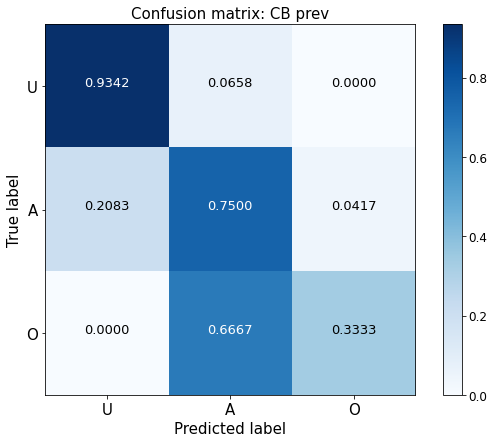

'print("CB new class prediction")\nclassification_report(to_pred_classes(Y_cbr_test_new,False),to_pred_classes(y_pred_test_cbr_new,False))\n\ncm = me.confusion_matrix(to_pred_classes(Y_cbr_test_new,False),to_pred_classes(y_pred_test_cbr_new,False),labels=labels_class)\nconfusion_matrix_plotting(cm,labels_class,True,"CB new")'

In [47]:
print("CB prev class prediction")
classification_report(to_pred_classes(Y_cbr_test_prev,False),to_pred_classes(y_pred_test_cbr_prev,False))

cm = me.confusion_matrix(to_pred_classes(Y_cbr_test_prev,False),to_pred_classes(y_pred_test_cbr_prev,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"CB prev")

"""print("CB new class prediction")
classification_report(to_pred_classes(Y_cbr_test_new,False),to_pred_classes(y_pred_test_cbr_new,False))

cm = me.confusion_matrix(to_pred_classes(Y_cbr_test_new,False),to_pred_classes(y_pred_test_cbr_new,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"CB new")"""

CB new+var class prediction
              precision    recall  f1-score   support

           A       0.55      0.66      0.60        35
           O       0.67      0.47      0.55        17
           U       0.89      0.87      0.88        99

    accuracy                           0.77       151
   macro avg       0.70      0.67      0.68       151
weighted avg       0.78      0.77      0.78       151



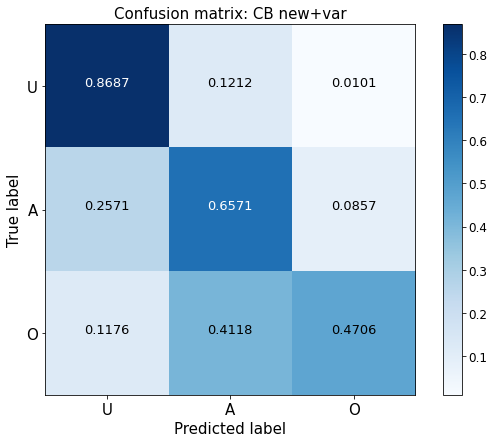

In [48]:
print("CB new+var class prediction")
classification_report(to_pred_classes(Y_cbr_test_var,False),to_pred_classes(y_pred_test_cbr_var,False))

cm = me.confusion_matrix(to_pred_classes(Y_cbr_test_var,False),to_pred_classes(y_pred_test_cbr_var,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"CB new+var")


Weighted Catboost  class prediction
              precision    recall  f1-score   support

           A       0.58      0.69      0.63        59
           O       0.69      0.42      0.52        26
           U       0.91      0.90      0.90       175

    accuracy                           0.80       260
   macro avg       0.72      0.67      0.69       260
weighted avg       0.81      0.80      0.80       260



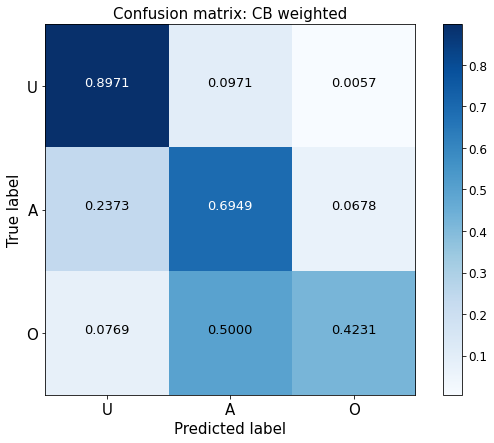

In [49]:
print("Weighted Catboost  class prediction")
classification_report(to_pred_classes(cb_weight_label,False),to_pred_classes(cb_weight_pred,False))

cm = me.confusion_matrix(to_pred_classes(cb_weight_label,False),to_pred_classes(cb_weight_pred,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"CB weighted")

PopPK class prediction
              precision    recall  f1-score   support

           A       0.50      0.11      0.19        35
           O       0.83      0.29      0.43        17
           U       0.71      0.98      0.82        99

    accuracy                           0.70       151
   macro avg       0.68      0.46      0.48       151
weighted avg       0.67      0.70      0.63       151



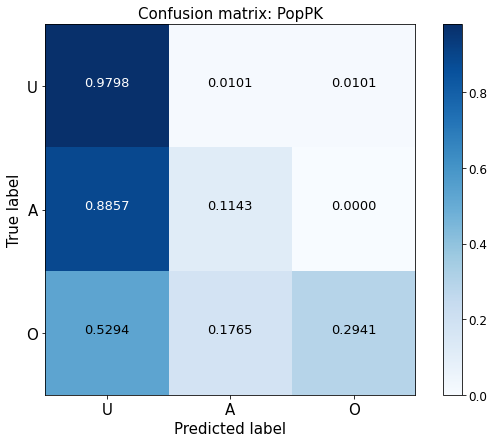

In [50]:
print("PopPK class prediction")
classification_report(to_pred_classes(Y_test_popPK,False),to_pred_classes(Y_popPK_pred ,False))

cm = me.confusion_matrix(to_pred_classes(Y_test_popPK,False),to_pred_classes(Y_popPK_pred,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"PopPK")


PopPK class prediction
              precision    recall  f1-score   support

           A       0.35      0.46      0.40        24
           O       0.50      0.56      0.53         9
           U       0.84      0.75      0.79        76

    accuracy                           0.67       109
   macro avg       0.56      0.59      0.57       109
weighted avg       0.70      0.67      0.68       109



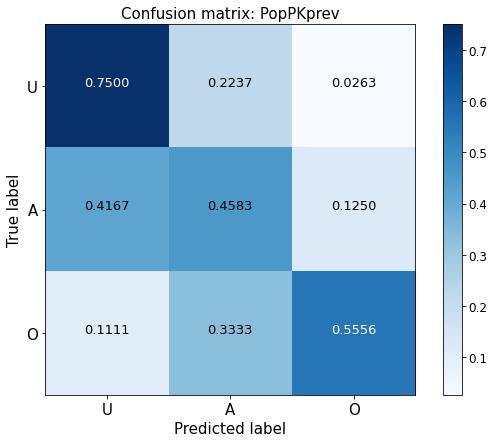

In [51]:
print("PopPK class prediction")
classification_report(to_pred_classes(Y_test_popPK_prev,False),to_pred_classes(Y_popPK_pred_prev ,False))

cm = me.confusion_matrix(to_pred_classes(Y_test_popPK_prev,False),to_pred_classes(Y_popPK_pred_prev,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"PopPKprev")

GP prev class prediction
              precision    recall  f1-score   support

           A       0.63      0.71      0.67        24
           O       0.60      0.33      0.43         9
           U       0.92      0.93      0.93        76

    accuracy                           0.83       109
   macro avg       0.72      0.66      0.67       109
weighted avg       0.83      0.83      0.83       109



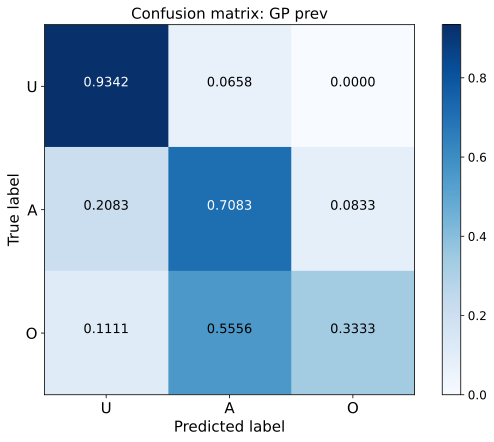

GP new class prediction
              precision    recall  f1-score   support

           A       0.50      0.54      0.52        35
           O       0.53      0.53      0.53        17
           U       0.88      0.85      0.86        99

    accuracy                           0.74       151
   macro avg       0.63      0.64      0.64       151
weighted avg       0.75      0.74      0.75       151



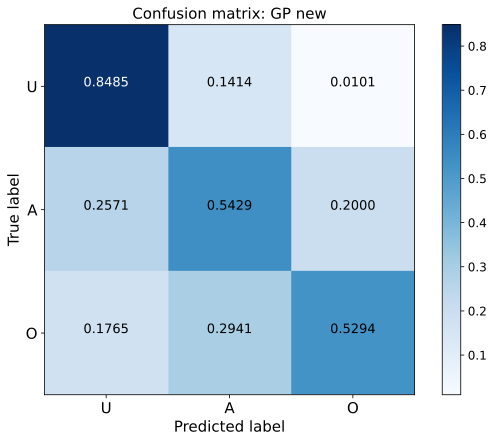

In [56]:
print("GP prev class prediction")
classification_report(to_pred_classes(Y_val_prev_dest,False),to_pred_classes(val_pred_prev,False))

cm = me.confusion_matrix(to_pred_classes(Y_val_prev_dest,False),to_pred_classes(val_pred_prev,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"GP prev")

print("GP new class prediction")
classification_report(to_pred_classes(Y_val_new_dest,False),to_pred_classes(val_pred_new,False))

cm = me.confusion_matrix(to_pred_classes(Y_val_new_dest,False),to_pred_classes(val_pred_new,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"GP new")

Weighted GP report:
              precision    recall  f1-score   support

           A       0.55      0.61      0.58        59
           O       0.55      0.46      0.50        26
           U       0.90      0.89      0.89       175

    accuracy                           0.78       260
   macro avg       0.67      0.65      0.66       260
weighted avg       0.78      0.78      0.78       260



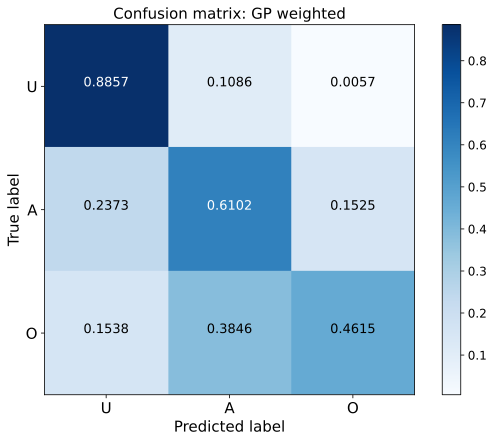

In [57]:
gp_tot_true = np.append(to_pred_classes(Y_val_new_dest,False),to_pred_classes(Y_val_prev_dest,False))
gp_tot_pred = np.append(to_pred_classes(val_pred_new,False),to_pred_classes(val_pred_prev,False))

print("Weighted GP report:")
classification_report(gp_tot_true,gp_tot_pred)

cm = me.confusion_matrix(gp_tot_true,gp_tot_pred,labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"GP weighted")

In [58]:
#TODO: if underdosing, find how much more to give, if overdosing, find how much less to give

# Uncertainty Visualizations

In [59]:
#link https://en.wikipedia.org/wiki/Error_function

#underdosing, calc sigma, then calc how many sigma's to each border, erf with that many

quantiles_new = gp_new.predict_quantiles(val_new,quantiles=[15.8655253931457,84.1344746068543])
quantiles_prev = gp_prev.predict_quantiles(val_prev,quantiles=[15.8655253931457,84.1344746068543])


sigma_new = np.subtract(deStandardize(quantiles_new[1],'Y',-1),deStandardize(quantiles_new[0],'Y',-1))/2
sigma_prev = np.subtract(deStandardize(quantiles_prev[1],'Y',-1),deStandardize(quantiles_prev[0],'Y',-1))/2


sigmas = np.append(sigma_new,sigma_prev)
real_conc = np.append(Y_val_new_dest,Y_val_prev_dest)
preds = np.append(val_pred_new,val_pred_prev)

(0.0, 80.0)

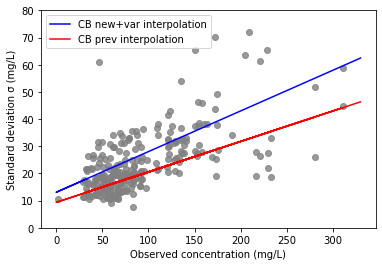

In [55]:
sigm_arr = cb_weight_sigm

plt.figure()

coef= np.polyfit(Y_cbr_test_var,y_pred_sigm_var,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(np.append(Y_cbr_test_var,[0,330]),poly1d_fn(np.append(Y_cbr_test_var,[0,330])),color='blue',label='CB new+var interpolation')

coef= np.polyfit(Y_cbr_test_prev,y_pred_sigm_prev,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(np.append(Y_cbr_test_prev,[0,330]),poly1d_fn(np.append(Y_cbr_test_prev,[0,330])),color='red',label='CB prev interpolation')

plt.scatter(cb_weight_label,sigm_arr,color='gray',alpha=0.8)
plt.xlabel("Observed concentration (mg/L)")
plt.ylabel("Standard deviation \u03C3 (mg/L)")
plt.legend(loc='upper left')
plt.ylim([0,80])

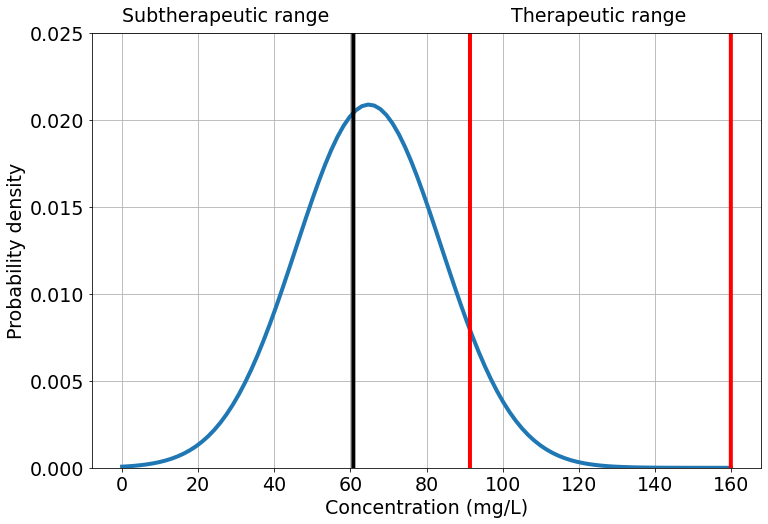

In [64]:
import scipy.stats as stats
fontsize_predef = 19
linewidth_predef = 4
idx = 40 

plt.figure(figsize=(12,8))
mu = y_pred_test_cbr_var[idx]
sigma = y_pred_sigm_var[idx]
x = np.linspace(0,160, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),linewidth=linewidth_predef)
plt.grid()
plt.plot([91.42,91.43],[0,0.03],color='red',linewidth=linewidth_predef)
plt.plot([159.99,160.00],[0,0.03],color='red',linewidth=linewidth_predef)
plt.plot([Y_cbr_test_var[idx]-0.01,Y_cbr_test_var[idx]],[0,0.03],color='black',linewidth=linewidth_predef)
plt.ylim([0,0.025])
x_start = 0.16
y_start = 0.9
plt.gcf().text(x_start+0,y_start, "Subtherapeutic range",fontsize=fontsize_predef)
plt.gcf().text(x_start+0.45,y_start, "Therapeutic range",fontsize=fontsize_predef)
plt.rc('axes', labelsize=fontsize_predef)    # fontsize of the x and y labels
plt.xticks(fontsize=fontsize_predef)    # fontsize of the tick labels
plt.yticks(fontsize=fontsize_predef)    # fontsize of the tick labels
plt.xlabel("Concentration (mg/L)",fontsize=fontsize_predef)
plt.ylabel("Probability density",fontsize=fontsize_predef)
plt.savefig("figures/pred_outp_new.jpeg")
plt.savefig("figures/pred_outp_new.pdf")
plt.savefig("figures/pred_outp_new.svg")

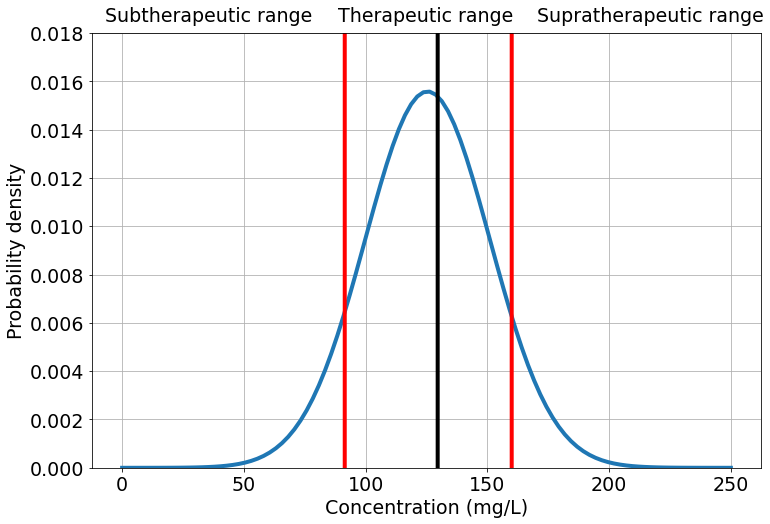

In [65]:
import scipy.stats as stats
fontsize_predef = 19
linewidth_predef = 4
idx = 67
 
plt.figure(figsize=(12,8))
mu = y_pred_test_cbr_prev[idx]
sigma = y_pred_sigm_prev[idx]
x = np.linspace(0,250, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),linewidth=linewidth_predef)
plt.grid()
plt.plot([91.42,91.43],[0,0.03],color='red',linewidth=linewidth_predef)
plt.plot([159.99,160.00],[0,0.03],color='red',linewidth=linewidth_predef)
plt.plot([Y_cbr_test_prev[idx]-0.01,Y_cbr_test_prev[idx]],[0,0.03],color='black',linewidth=linewidth_predef)
plt.ylim([0,0.018])
x_start = 0.14
y_start = 0.9
plt.gcf().text(x_start+0,y_start, "Subtherapeutic range",fontsize=fontsize_predef)
plt.gcf().text(x_start+0.27,y_start, "Therapeutic range",fontsize=fontsize_predef)
plt.gcf().text(x_start+0.5,y_start, "Supratherapeutic range",fontsize=fontsize_predef)
plt.rc('axes', labelsize=fontsize_predef)    # fontsize of the x and y labels
plt.xticks(fontsize=fontsize_predef)    # fontsize of the tick labels
plt.yticks(fontsize=fontsize_predef)    # fontsize of the tick labels
plt.xlabel("Concentration (mg/L)")
plt.ylabel("Probability density")
plt.savefig("figures/pred_outp_prev.jpeg")
plt.savefig("figures/pred_outp_prev.pdf")
plt.savefig("figures/pred_outp_prev.svg")

In [47]:
#res,values,cov,ce = error_bar_quality_quantile(real_conc,preds,sigmas)
res_gp_prev,values,cov_gp_prev,ce_gp_prev = error_bar_quality_quantile(Y_val_prev_dest,val_pred_prev,sigma_prev)
res_gp_new,values,cov_gp_new,ce_gp_new = error_bar_quality_quantile(Y_val_new_dest,val_pred_new,sigma_new)

#res2,values2,cov2,ce2 = error_bar_quality_quantile(cb_weight_label,cb_weight_pred,cb_weight_sigm)
res_gbt_prev,values,cov_gbt_prev,ce_gbt_prev = error_bar_quality_quantile(Y_cbr_test_prev,y_pred_test_cbr_prev,y_pred_sigm_prev)
res_gbt_new,values,cov_gbt_new,ce_gbt_new = error_bar_quality_quantile(Y_cbr_test_var,y_pred_test_cbr_var,y_pred_sigm_var)

--


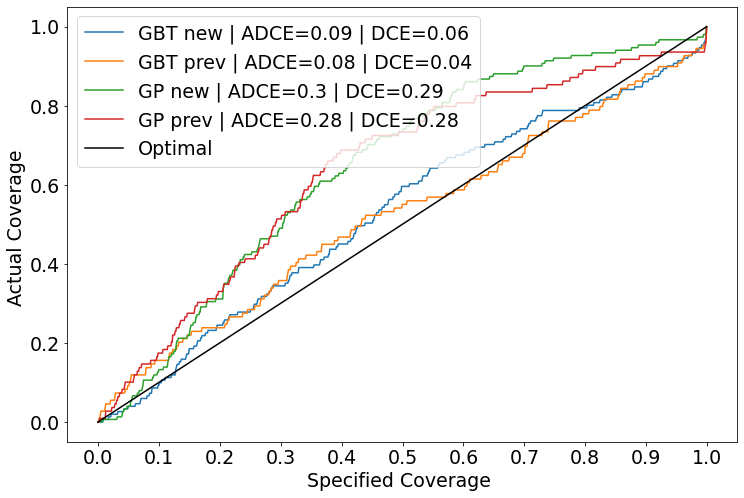

In [48]:
fontsize_predef = 19

plt.figure(figsize=(12,8))
ax = plt.gca()
print("--")

#diff = np.sum(np.abs(np.subtract(values,res)))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gbt_new,label='GBT new | ADCE='+str(np.round(cov_gbt_new,2))+' | DCE='+str(np.round(ce_gbt_new,2)))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gbt_prev,label='GBT prev | ADCE='+str(np.round(cov_gbt_prev,2))+' | DCE='+str(np.round(ce_gbt_prev,2)))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gp_new,label='GP new | ADCE='+str(np.round(cov_gp_new,2))+' | DCE='+str(np.round(ce_gp_new,2)))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gp_prev,label='GP prev | ADCE='+str(np.round(cov_gp_prev,2))+' | DCE='+str(np.round(ce_gp_prev,2)))
plt.plot(np.arange(0,1.0,1.0/len(values)),values,label='Optimal',color="black")



plt.xticks(np.arange(0, 1.1, 0.1),np.round(values[0::100],2), fontsize=fontsize_predef)#, np.round(values[0::10],2))
plt.yticks(fontsize=fontsize_predef)
#plt.locator_params(axis='x', nbins=len(values)/10)
plt.xlabel('Specified Coverage ',fontsize=fontsize_predef)
plt.ylabel('Actual Coverage ',fontsize=fontsize_predef)
    
plt.legend(loc='upper left', fontsize=fontsize_predef)

if internal_test_bool:
    plt.savefig("figures/coverage_plot_GUH.pdf")
    plt.savefig("figures/coverage_plot_GUH.jpeg")
    plt.savefig("figures/coverage_plot_GUH.svg")
else:
    plt.savefig("figures/coverage_plot_UMCG.pdf")
    plt.savefig("figures/coverage_plot_UMCG.jpeg")
    plt.savefig("figures/coverage_plot_UMCG.svg")
    
plt.show() 

In [66]:
gp_prob = False
print_all = True

if gp_prob: 

    classes = np.append(to_pred_classes(val_pred_new,False),to_pred_classes(val_pred_prev,False))
    real = np.append(to_pred_classes(Y_val_new_dest,False),to_pred_classes(Y_val_prev_dest,False))
    preds = np.append(val_pred_new,val_pred_prev)
    sigmas = np.append(sigma_new,sigma_prev)
    real_conc = np.append(Y_val_new_dest,Y_val_prev_dest)
else:
    
    classes = to_pred_classes(cb_weight_pred,False)
    real = to_pred_classes(cb_weight_label,False)
    preds = cb_weight_pred
    sigmas = cb_weight_sigm
    real_conc = cb_weight_label
    
under_avg = []
perfect_avg = []
over_avg = []
    
for i in range(0,len(classes)):
    pred = preds[i]
    sigma = sigmas[i]
    real_stat = real[i]
    status = classes[i]
    real_conc_i = real_conc[i]
    
    
    
    underdosing_und = 0
    underdosing_up = 4*MIC
    up_diff = (underdosing_up-pred)/sigma
    down_diff = (-100000*MIC-pred)/sigma
    underdosing = (erf(up_diff/sqrt(2)) - erf(down_diff/sqrt(2)) )*50

    perfect_und = 4*MIC
    perfect_up = toxic_threshold
    up_diff = (perfect_up-pred)/sigma
    down_diff = (perfect_und-pred)/sigma
    perfect = (erf(up_diff/sqrt(2)) - erf(down_diff/sqrt(2)) )*100/2
    
    toxic_und = toxic_threshold
    down_diff = (toxic_und-pred)/sigma
    toxic = (1 - erf(down_diff/sqrt(2)) )*100/2
    
    print("Predicts a "+status)
    print(i)
    if status != real[i]:
        if real_stat == "U":
            print("\tThe real status was: Underdosing, certainty of this status was {0:.2f}% ".format(underdosing))
        elif real_stat == "A":
            print("\tThe real status was: Adequate dosing, certainty of this status was {0:.2f}%".format(perfect))
        else:
            print("\tThe real status was: Overdosing, certainty of this status was {0:.2f}%".format(toxic))
      
    if status == "Underdosing" and status != real[i] :
        under_avg.append(underdosing)
    elif status == "Adequate dosing" and status != real[i]:
        perfect_avg.append(perfect)
    elif status == "Overdosing" and status != real[i] and real[i]=="Underdosing":
        over_avg.append(toxic)

    #if status == "Underdosing":
    print("\tUnderdosing with {0:.2f}% certainty ".format(underdosing))
    #elif status == "Adequate dosing":
    print("\tAdequate dosing with {0:.2f}% certainty".format(perfect))
    #else:
    print("\tOverdosing with {0:.2f}% certainty".format(toxic))
    
    if print_all:
        print("Predicted average value  %.2f (+/- %.2f) mg/L" % (pred,sigma))
        print("Observed value %.2f mg/L" % (real_conc_i))
    print("----")
    
print("Average underdosing certainty: %.2f"%(np.mean(under_avg)))
print("Average Adequate certainty: %.2f"%(np.mean(perfect_avg)))
print("Average overdosing certainty: %.2f"%(np.mean(over_avg)))

Predicts a U
0
	Underdosing with 98.66% certainty 
	Adequate dosing with 1.34% certainty
	Overdosing with 0.00% certainty
Predicted average value  45.10 (+/- 20.92) mg/L
Observed value 33.39 mg/L
----
Predicts a U
1
	Underdosing with 98.73% certainty 
	Adequate dosing with 1.27% certainty
	Overdosing with 0.00% certainty
Predicted average value  43.35 (+/- 21.50) mg/L
Observed value 33.17 mg/L
----
Predicts a U
2
	Underdosing with 98.84% certainty 
	Adequate dosing with 1.16% certainty
	Overdosing with 0.00% certainty
Predicted average value  42.22 (+/- 21.67) mg/L
Observed value 39.37 mg/L
----
Predicts a U
3
	Underdosing with 98.38% certainty 
	Adequate dosing with 1.62% certainty
	Overdosing with 0.00% certainty
Predicted average value  45.24 (+/- 21.58) mg/L
Observed value 32.09 mg/L
----
Predicts a U
4
	Underdosing with 94.68% certainty 
	Adequate dosing with 5.32% certainty
	Overdosing with 0.00% certainty
Predicted average value  56.10 (+/- 21.88) mg/L
Observed value 37.25 mg/L


Mean of empty slice.
invalid value encountered in double_scalars


# SHAP

In [50]:
#cbr_var, cbr_prev
import matplotlib.cm as cm

In [51]:
shap_var_pd = X_cbr_train_prev.rename(columns={"Cl8u_eGFR": "CLCR","Creat_s":"Serum creatinine","Bili":"Bilirubine","Length":"Height"})

In [52]:
plt.rcParams['figure.dpi'] = 300

In [53]:
shap_var_pd_var_test = X_cbr_test_var.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","Albumine":"Albumin","Thrombo":"Thrombocytes","Length":"Height"})
shap_var_pd_var_train = X_cbr_train_var.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","Albumine":"Albumin","Thrombo":"Thrombocytes","Length":"Height"})

In [54]:
shap_var_pd_test = X_cbr_test_prev.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","prevCon":"Previous concentration","Albumine":"Albumin","Thrombo":"Platelets","DoseHour":"Dose per hour","Length":"Height"})
shap_prev_pd_train = X_cbr_train_prev.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","prevCon":"Previous concentration","Albumine":"Albumin","Thrombo":"Platelets","DoseHour":"Dose per hour","Length":"Height"})

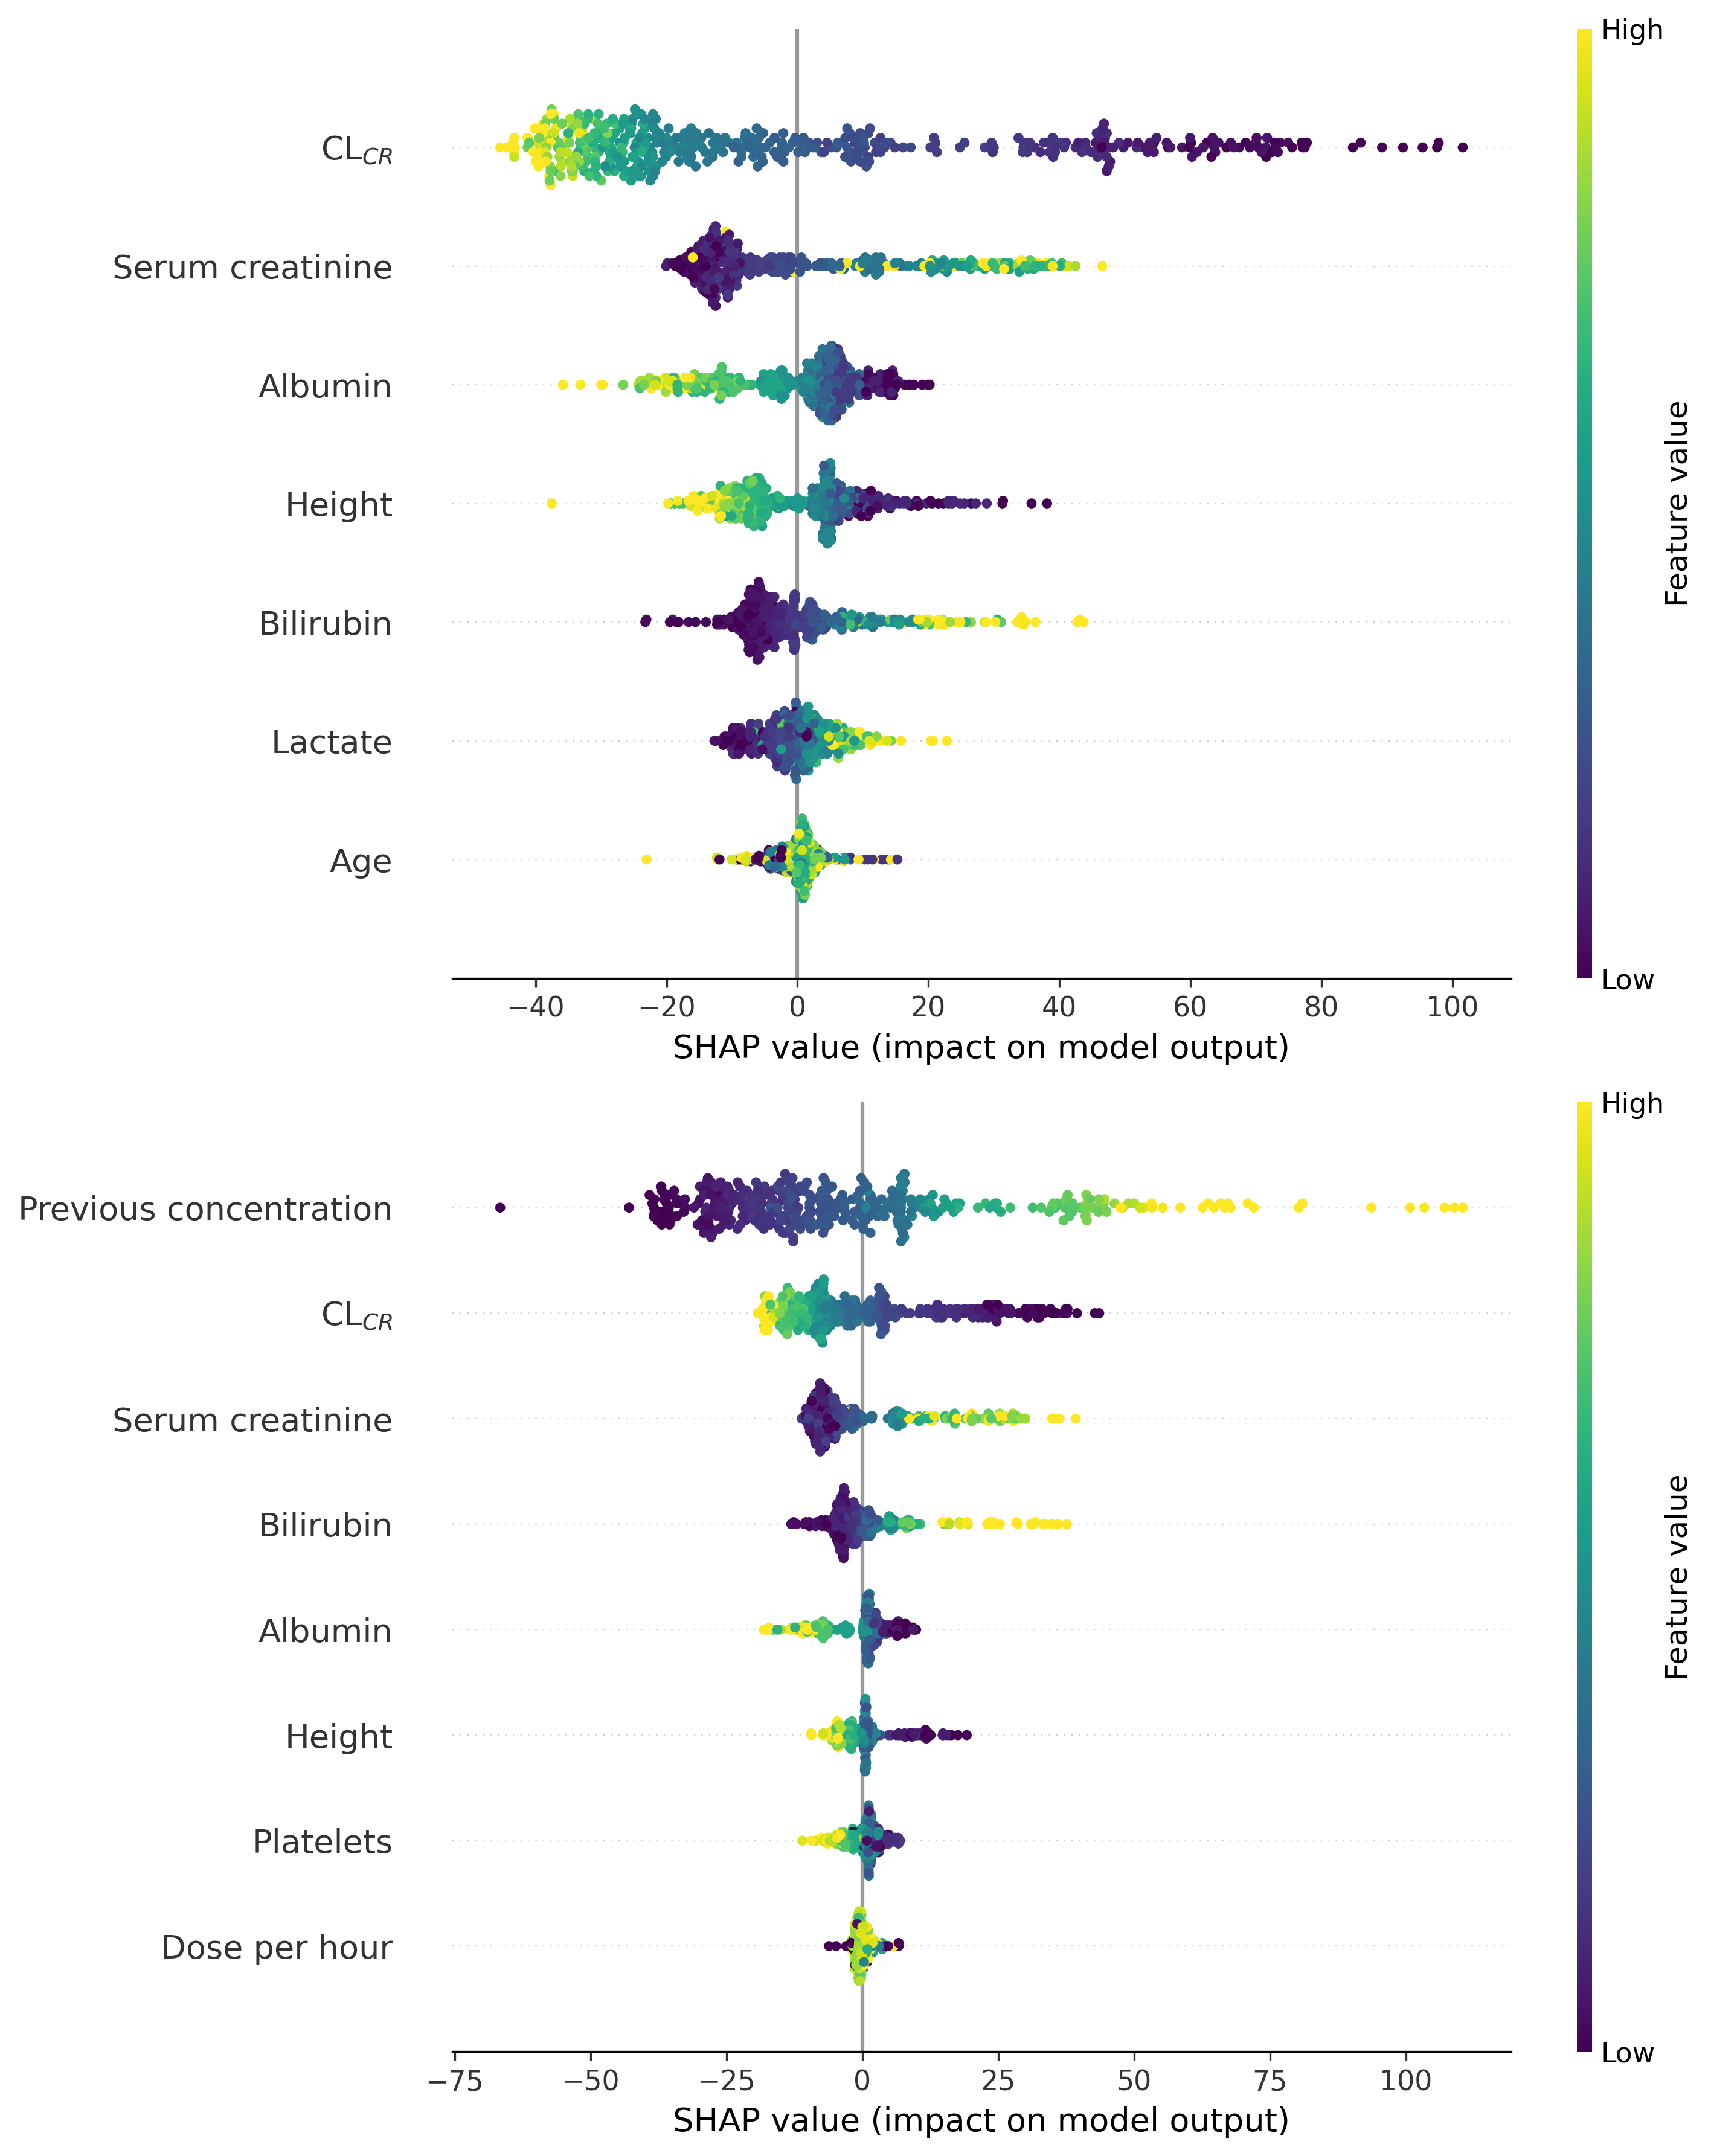

In [56]:
explainer = shap.TreeExplainer(cbr_prev)
shap_values = explainer.shap_values(X_cbr_train_prev)
my_cmap = plt.get_cmap('viridis')

explainer_prior = shap.TreeExplainer(cbr_var)
shap_values_prior = explainer_prior.shap_values(X_cbr_train_var)

plt.figure(figsize=(10,12))

plt.subplot(2,1,1)
shap.summary_plot(shap_values_prior, shap_var_pd_var_train,show=False,plot_size=None)
plt.subplot(2,1,2)
shap.summary_plot(shap_values, shap_prev_pd_train,show=False,plot_size=None)#,feature_names=["Length","Serum creat.","Thrombo","Bilirubine","Albumine","DoseHour","Prev. Con.","CLCR"])
plt.tight_layout()
#plt.show()

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            
plt.savefig("figures/shap_cbr.pdf")
plt.savefig("figures/shap_cbr.jpeg")
plt.savefig("figures/shap_cbr.svg")
plt.savefig("figures/shap_cbr.tif")
plt.savefig("figures/shap_cbr.eps")

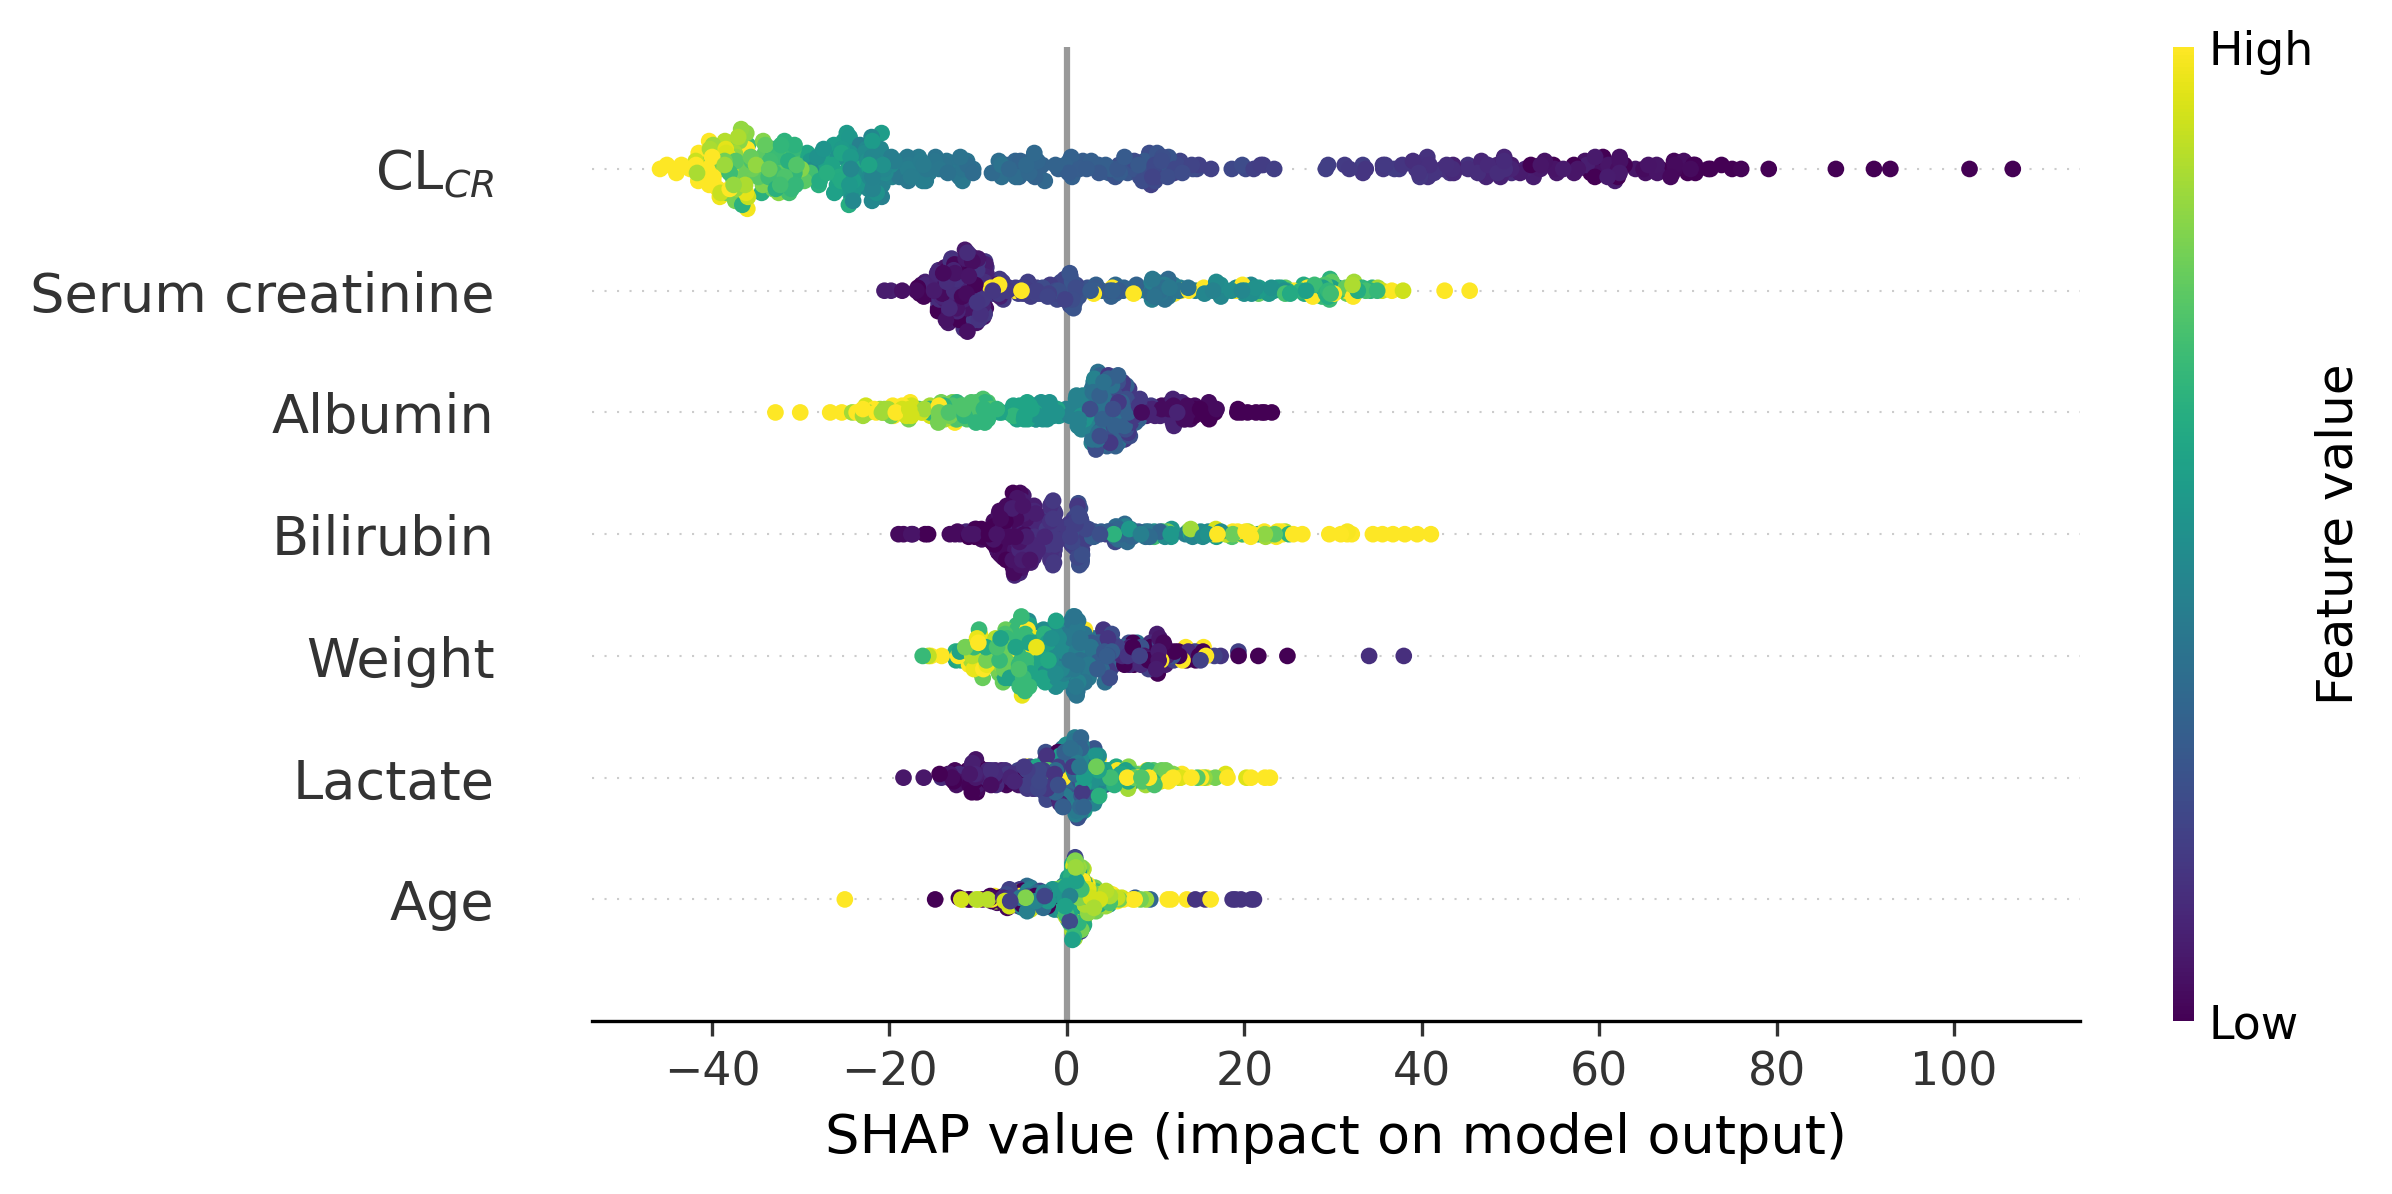

In [67]:
explainer = shap.TreeExplainer(cbr_var)
shap_values = explainer.shap_values(X_cbr_train_var)
my_cmap = plt.get_cmap('viridis')

plt.figure()
shap.summary_plot(shap_values, shap_var_pd_var_train,show=False)#,feature_names=["Length","Serum creat.","Thrombo","Bilirubine","Albumine","DoseHour","Prev. Con.","CLCR"])

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            
#shap.dependence_plot("Bilirubine", shap_values, X_cbr_train_prev)
#shap.force_plot(explainer.expected_value, shap_values, X_cbr_train_prev)

In [68]:
# sum over each feature
fi_shap = abs(shap_values).sum(0)

print(fi_shap)
# Normalize
fi_shap = fi_shap/fi_shap.sum() ; 
fi_shap.sum(),fi_shap.shape

print(fi_shap)

[ 1356.08896062  2489.5320316   2138.32491931  5604.69726325
  3171.3001676   3701.26024867 13499.80566425]
[0.04242948 0.07789279 0.06690417 0.17536046 0.09922403 0.11580549
 0.42238358]


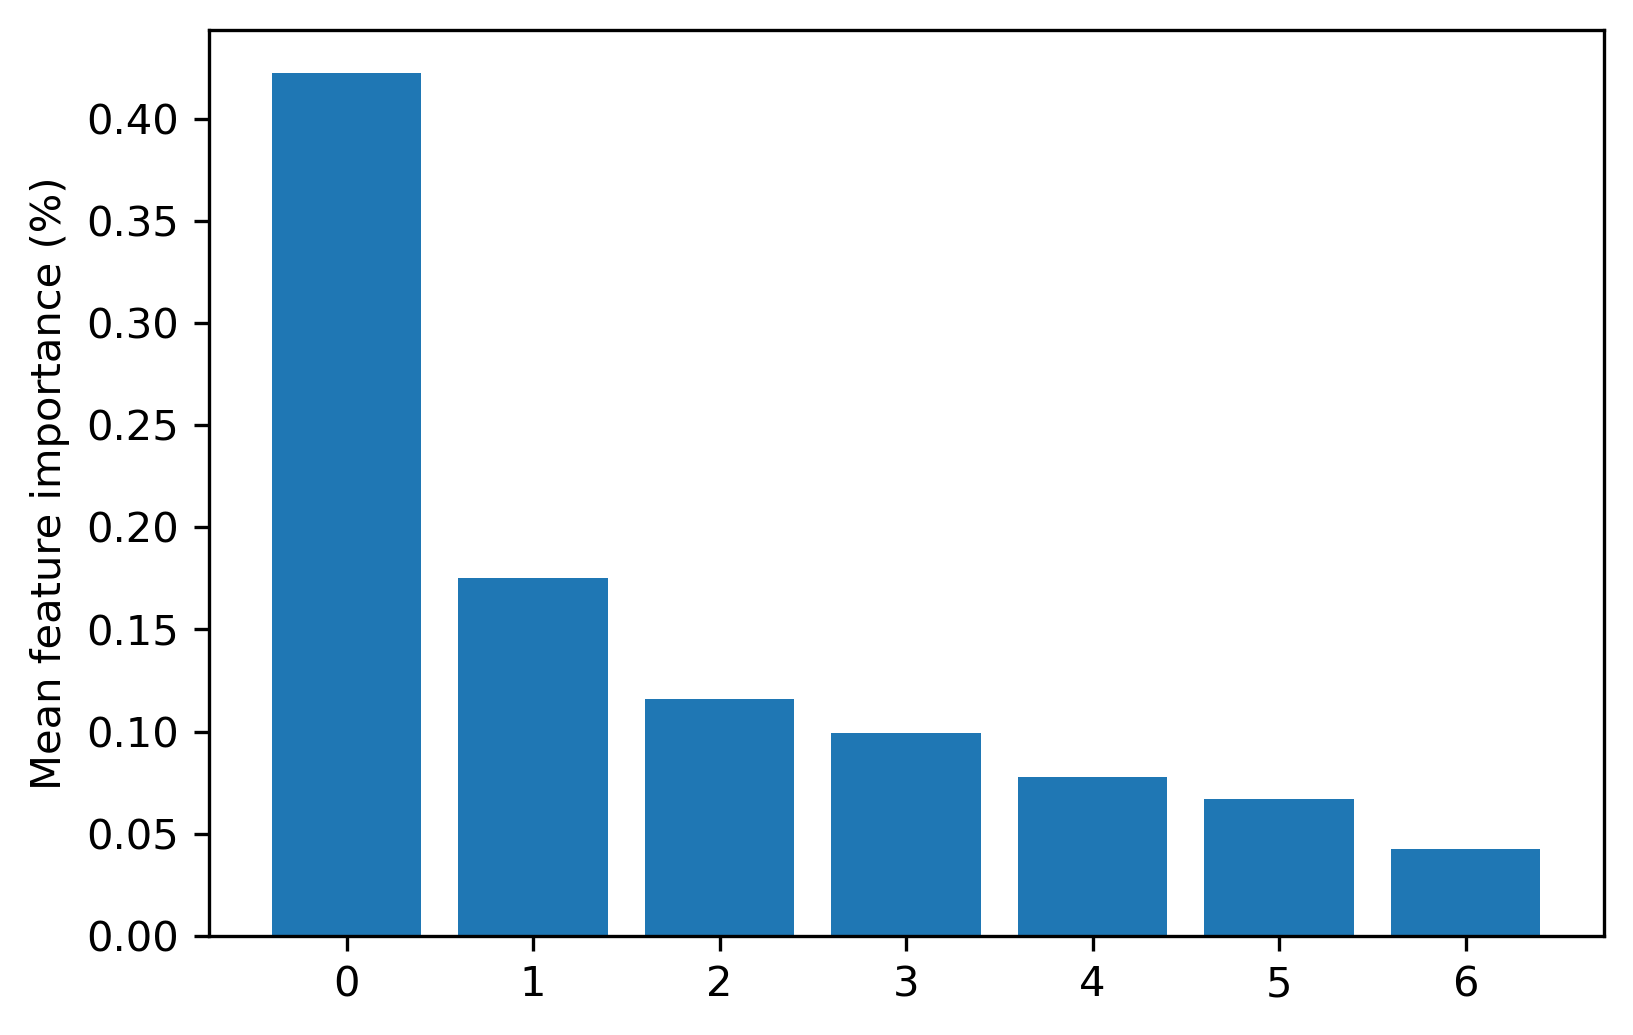

In [69]:
plt.figure(figsize=(6,4))
indices = np.argsort(fi_shap)[::-1]
plt.bar(range(len(fi_shap)),fi_shap[indices])
#plt.xticks(range(len(fi_shap)), X_cbr_train_var.columns[indices],rotation=90,fontsize=11)
plt.ylabel("Mean feature importance (%)")#,fontsize=13)
#plt.tight_layout()
plt.show()

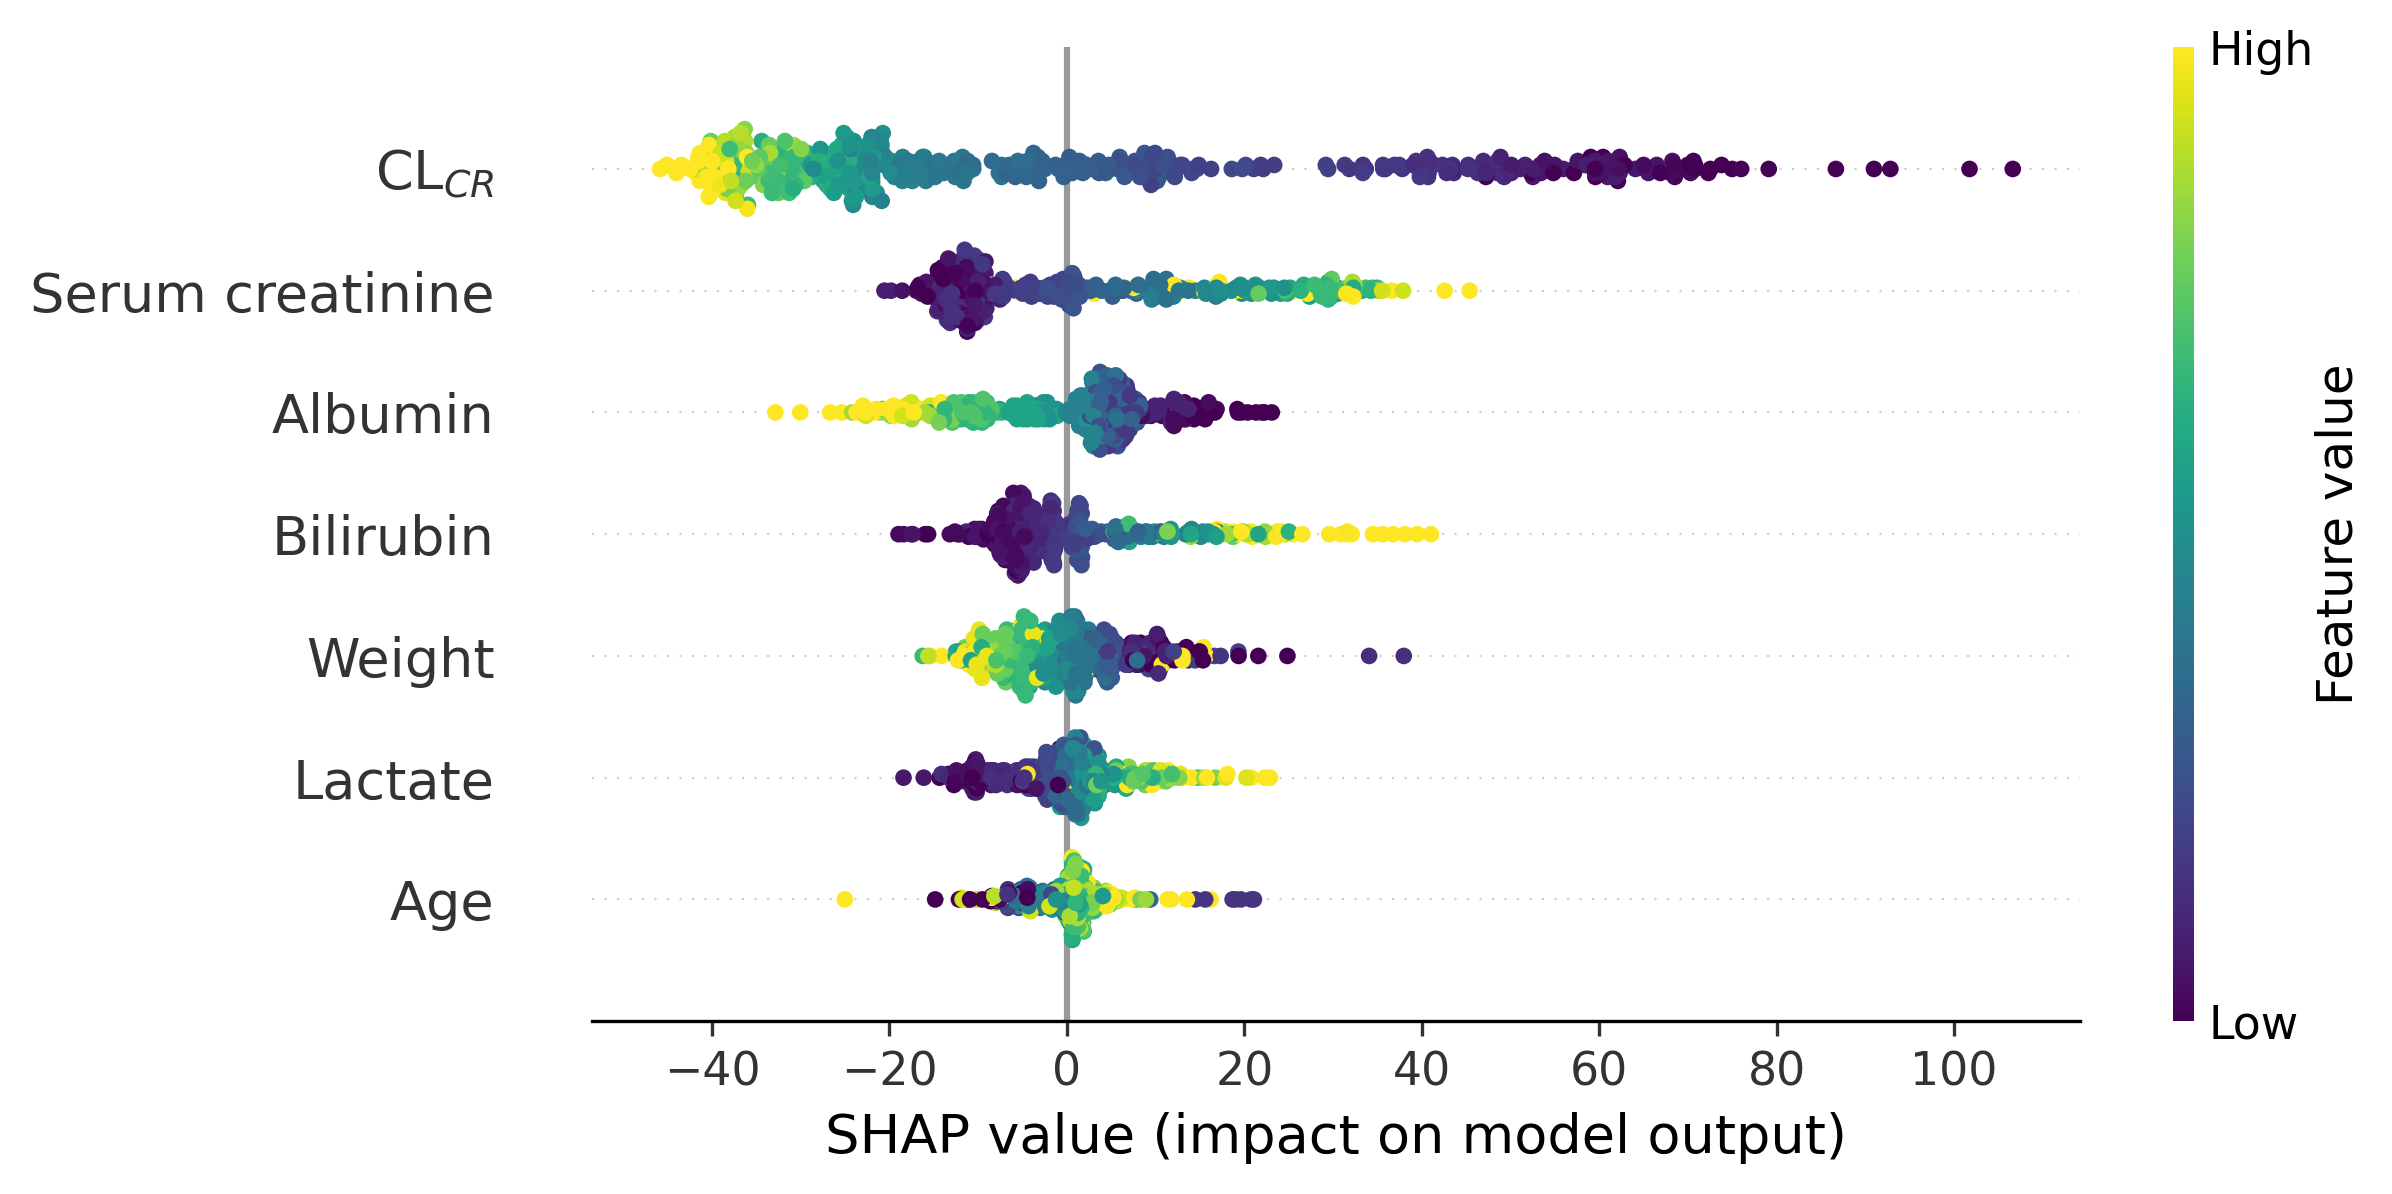

In [70]:
explainer = shap.TreeExplainer(cbr_var)
shap_values = explainer.shap_values(X_cbr_train_var)

my_cmap = plt.get_cmap('viridis')

plt.figure()
shap.summary_plot(shap_values, shap_var_pd_var_train,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
#shap.dependence_plot("Albumine", shap_values, X_cbr_train_var)
#shap.force_plot(explainer.expected_value, shap_values, X_cbr_train_var)

In [72]:
explainer = shap.TreeExplainer(cbr_var)
shap_values_test = explainer.shap_values(X_cbr_test_var)
print(X_cbr_test_var.iloc[13,:])

shap.force_plot(explainer.expected_value, shap_values_test[13,:], X_cbr_test_var.iloc[13,:])

my_cmap = plt.get_cmap('viridis')

plt.figure()

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)



Age             73.000
Weight          45.000
Lactate          5.400
Serum Creat      0.240
Bilirubine       0.300
Albumine        27.000
ClCr           121.253
Name: 95, dtype: float64


<Figure size 1800x1200 with 0 Axes>

In [65]:
shap_var_pd_test.iloc[67,:].index

Index(['Height', 'Serum creatinine', 'Platelets', 'Bilirubin', 'Albumin',
       'Dose per hour', 'Previous concentration', 'CL$_{CR}$'],
      dtype='object')

Height                    170.00000
Serum creatinine            0.51000
Platelets                 248.00000
Bilirubin                   1.70000
Albumin                    20.00000
Dose per hour             602.52123
Previous concentration    173.40000
CL$_{CR}$                  72.60270
Name: 548, dtype: float64


<Figure size 1800x1200 with 0 Axes>

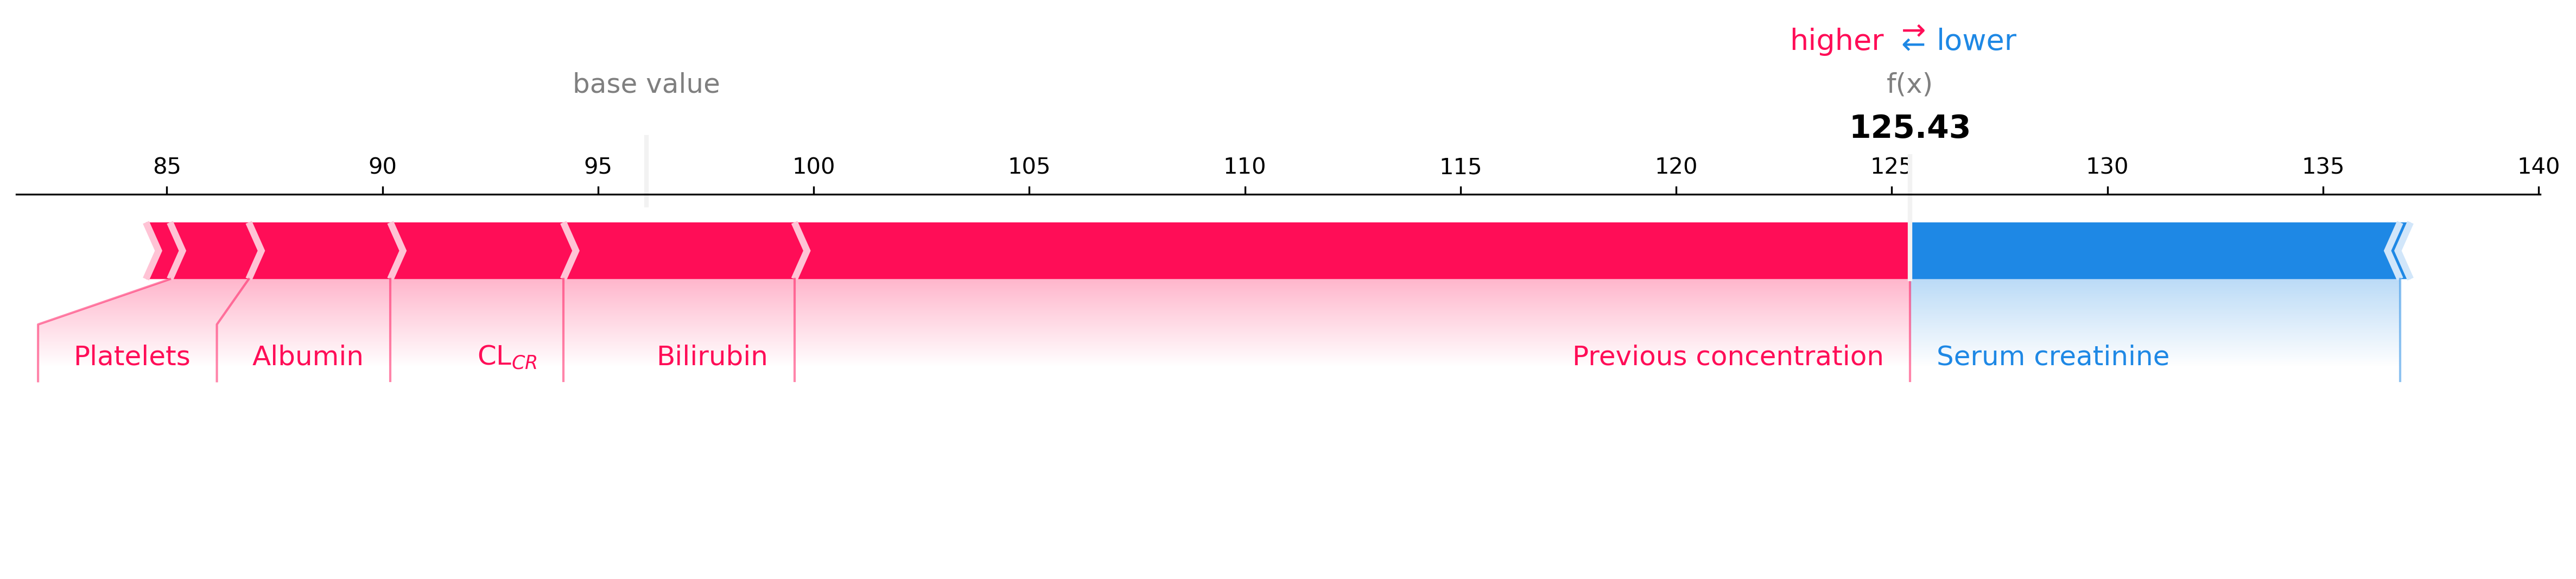

In [81]:
explainer = shap.TreeExplainer(cbr_prev)
shap_values_test = explainer.shap_values(X_cbr_test_prev)
print(shap_var_pd_test.iloc[67,:])
plt.figure()
plt.gcf().subplots_adjust(top=5)
fig = shap.force_plot(explainer.expected_value, shap_values_test[67,:], shap_var_pd_test.iloc[67,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)#.savefig("figures/patient_prev.jpeg")
plt.savefig("figures/patient_prev.jpeg", bbox_inches="tight")
plt.savefig("figures/patient_prev.pdf", bbox_inches="tight")
plt.savefig("figures/patient_prev.svg", bbox_inches="tight")

In [83]:
explainer.expected_value

96.11761418482386

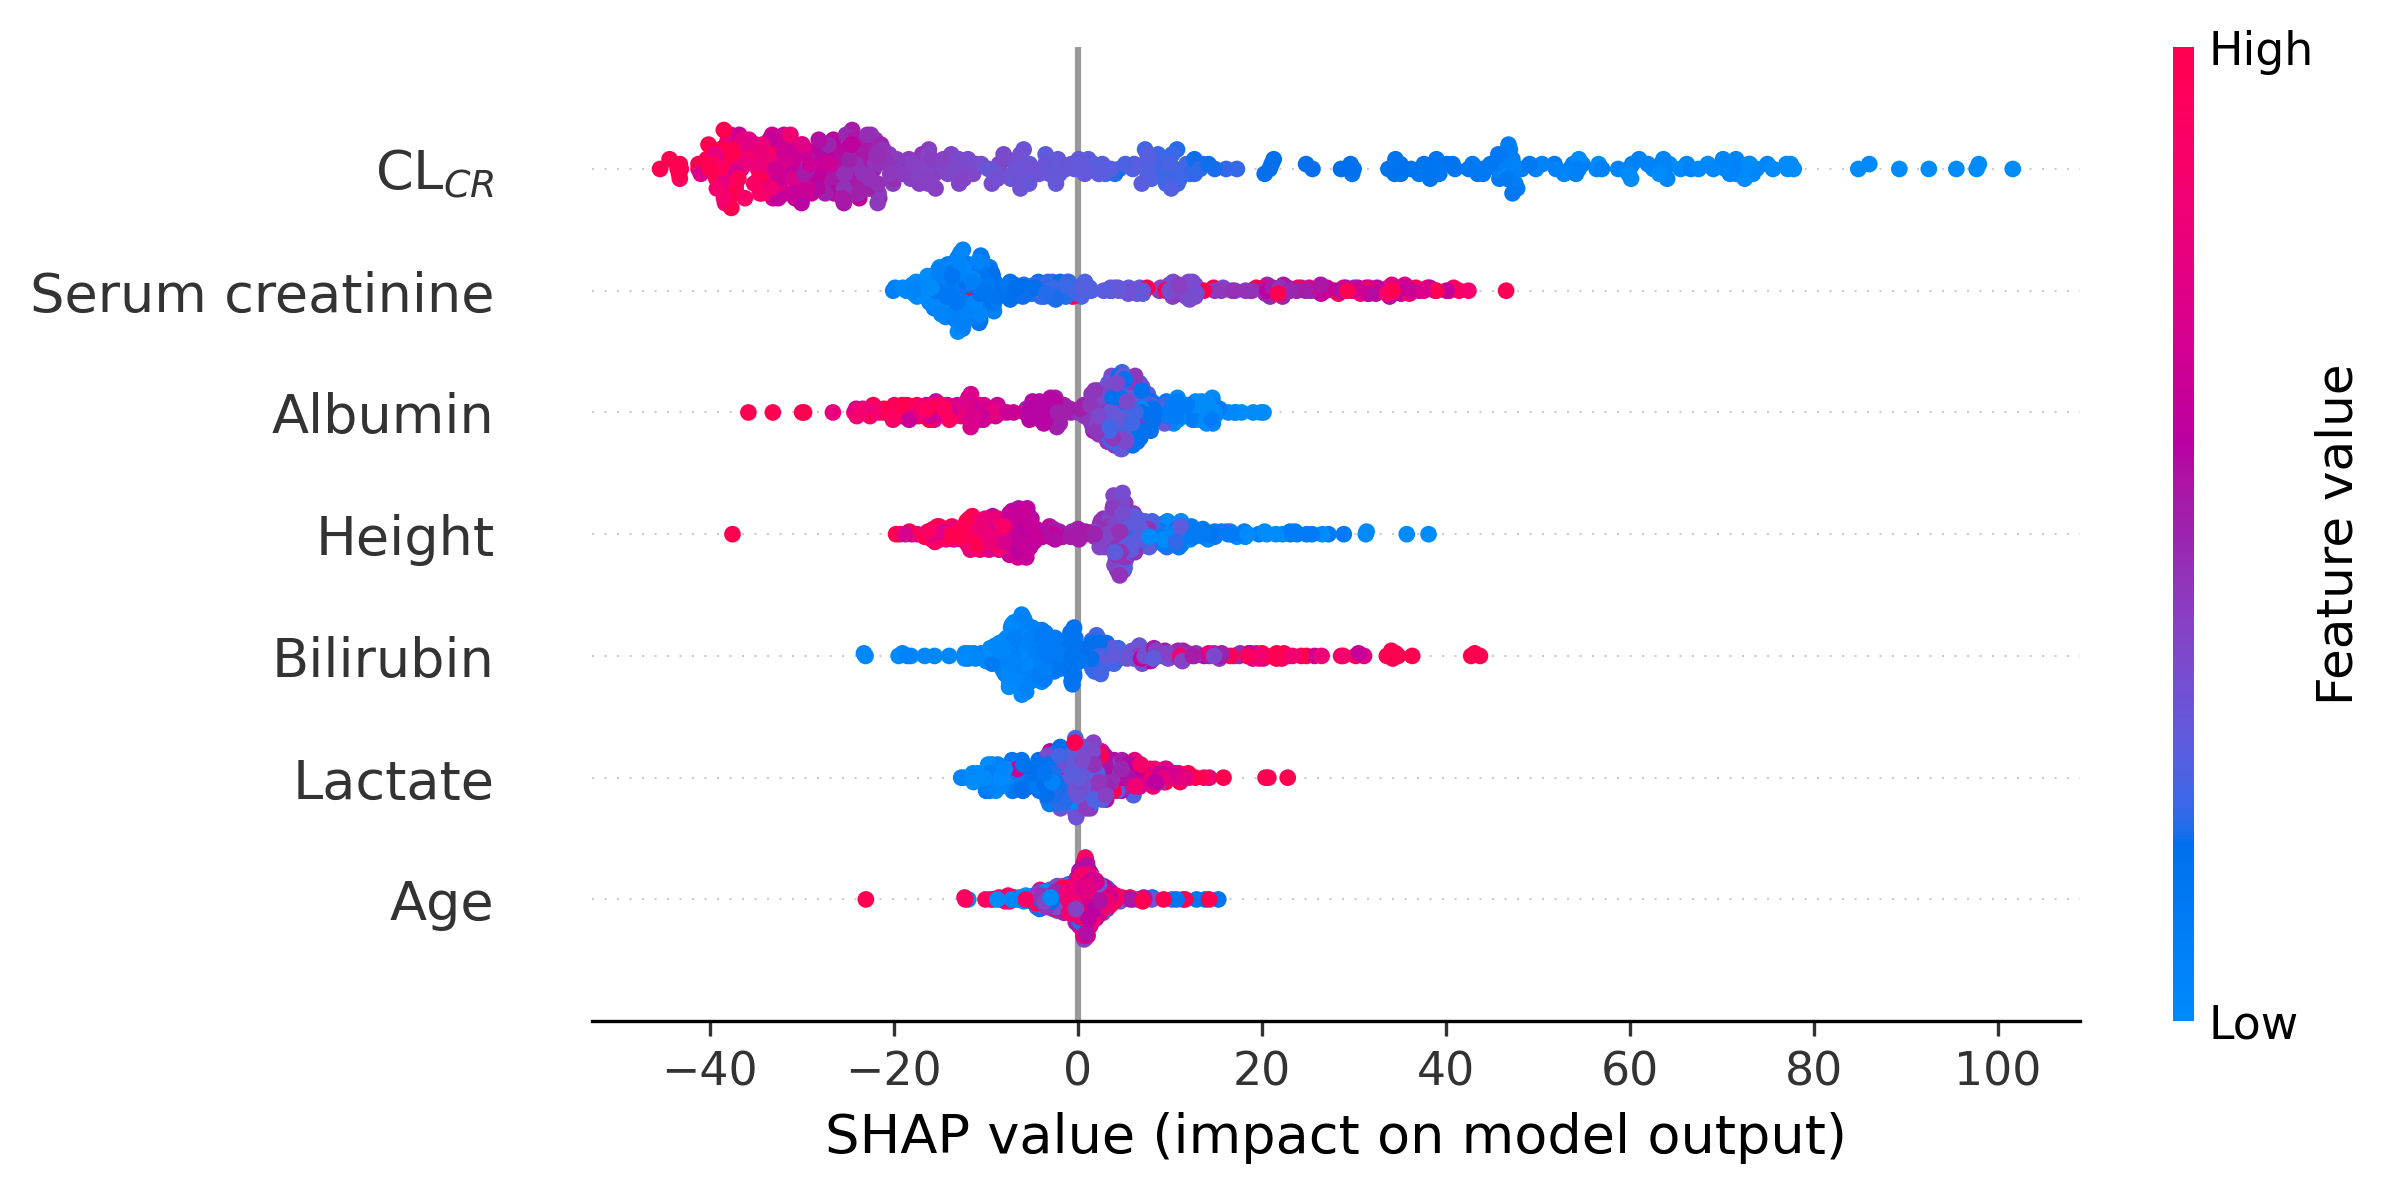

<Figure size 1800x1200 with 0 Axes>

In [85]:
explainer = shap.TreeExplainer(cbr_var)
shap_values = explainer.shap_values(X_cbr_train_var)
shap.summary_plot(shap_values, shap_var_pd_var_train)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            
shap_values_test = explainer.shap_values(X_cbr_test_var)
#shap.force_plot(explainer.expected_value, shap_values_test[26,:], X_cbr_test_var.iloc[26,:],matplotlib=True)

Age                  59.0000
Height              175.0000
Lactate              11.7000
Serum creatinine      0.7200
Bilirubin             0.6000
Albumin              33.0000
CL$_{CR}$            90.9311
Name: 265, dtype: float64


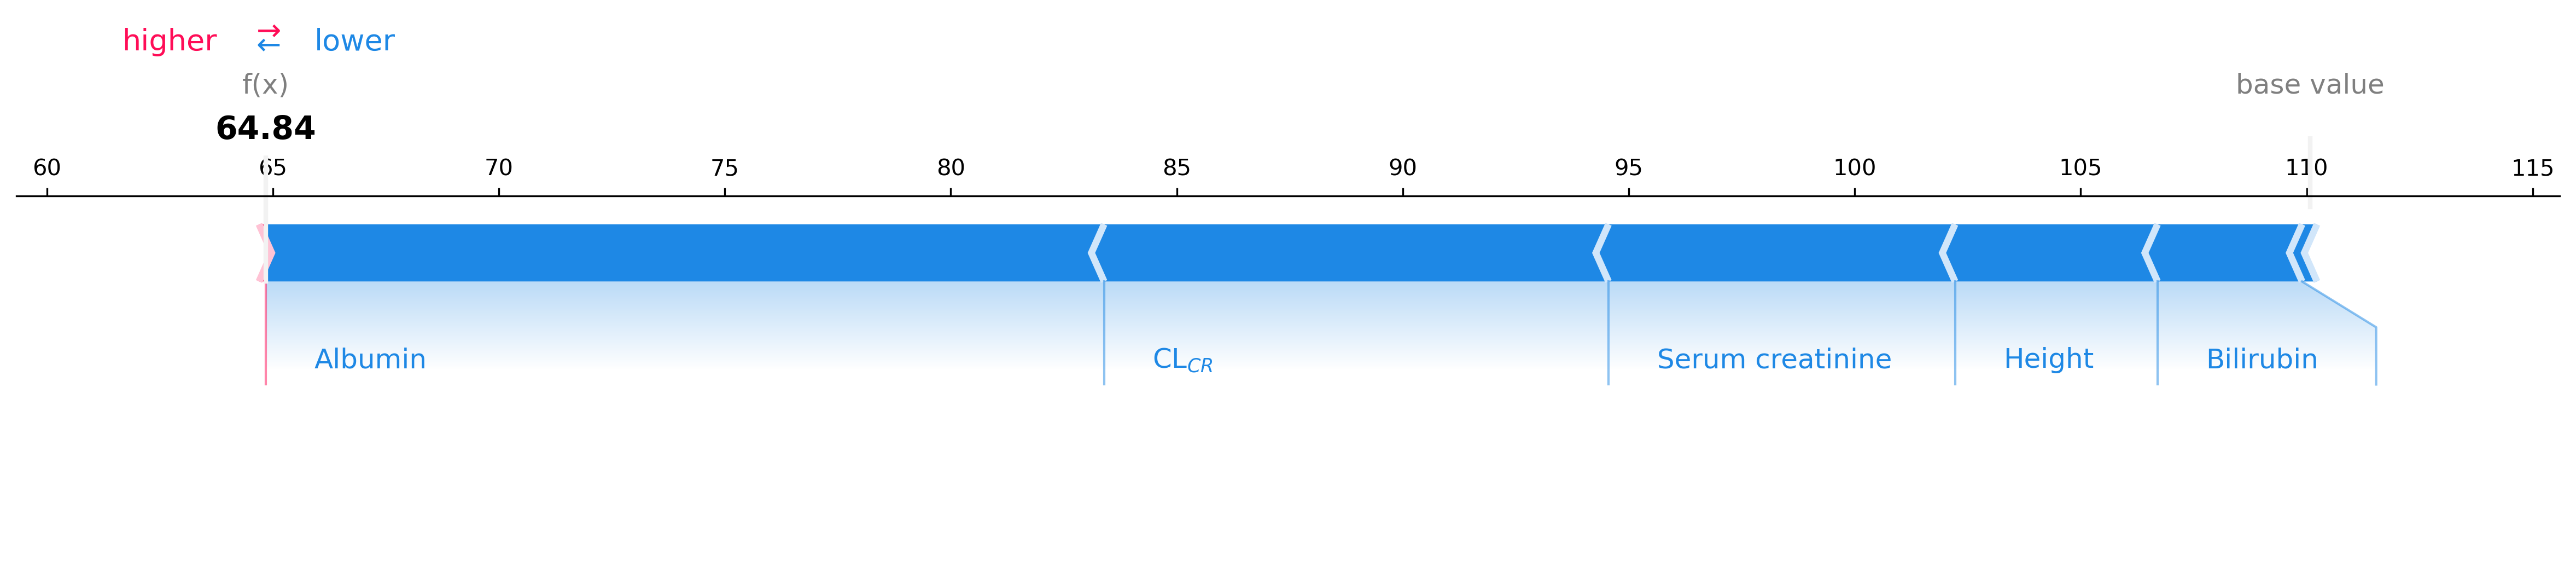

In [86]:
print(shap_var_pd_var_test.iloc[40,:])
shap.force_plot(explainer.expected_value, shap_values_test[40,:], shap_var_pd_var_test.iloc[40,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)
plt.savefig("figures/patient_priori.jpeg", bbox_inches="tight")
plt.savefig("figures/patient_priori.pdf", bbox_inches="tight")
plt.savefig("figures/patient_priori.svg", bbox_inches="tight")

In [87]:
#SHAP werkt niet op GPy

In [72]:
#PopPK patient case study
full_pd = GUH_poppk_isis[GUH_poppk_isis.ISISID.isin(test_df_cbr.PatientID)].sort_values(["ISISID","OrIndex"])
Keep_cols = ["DV","IPRED","PRED","CL","V1","Q","V2","Km","Vmax","SD","WGT","MCRCL"]
patient_prev = full_pd.loc[243][Keep_cols]#ISISID = 68746
patient_new = full_pd.loc[95][Keep_cols]#ISISID = 65587

In [73]:
patient_new

DV        60.80
IPRED     59.00
PRED      55.00
CL         7.71
V1         6.37
Q         15.90
V2        11.50
Km        37.10
Vmax     354.00
SD         7.90
WGT       72.00
MCRCL     90.90
Name: 95, dtype: float64

In [74]:
patient_prev

DV       130.00
IPRED    161.00
PRED      68.40
CL         2.36
V1         6.01
Q         15.30
V2        10.90
Km        37.10
Vmax     354.00
SD        18.10
WGT       68.00
MCRCL     72.60
Name: 243, dtype: float64

# Bland-Altmann

In [46]:
save = False
log_plot = True


if log_plot:
    Y_val_plot_cbr = np.log(Y_cbr_test_var)
    Y_val_plot_pred_cbr= np.log(y_pred_test_cbr_var)
else:
    Y_val_plot_cbr = Y_cbr_test_var
    Y_val_plot_pred_cbr= y_pred_test_cbr_var

diff_cbr = np.subtract(Y_val_plot_pred_cbr,Y_val_plot_cbr)

md_cbr = np.mean(diff_cbr)
sd_cbr = np.std(diff_cbr)

if log_plot:
    Y_val_plot_poppk =np.log( Y_test_popPK )
    Y_val_plot_pred_poppk= np.log(Y_popPK_pred)
else:
    Y_val_plot_poppk =Y_test_popPK 
    Y_val_plot_pred_poppk= Y_popPK_pred

diff_poppk = np.subtract(Y_val_plot_pred_poppk,Y_val_plot_poppk)

md_poppk = np.mean(diff_poppk)
sd_poppk = np.std(diff_poppk)

if log_plot:
    Y_val_plot_cbr_prev =  np.log(Y_cbr_test_prev )
    Y_val_plot_pred_cbr_prev= np.log(y_pred_test_cbr_prev)
else:
    Y_val_plot_cbr_prev =  Y_cbr_test_prev 
    Y_val_plot_pred_cbr_prev= y_pred_test_cbr_prev

diff_cbr_prev = np.subtract(Y_val_plot_pred_cbr_prev,Y_val_plot_cbr_prev)

md_cbr_prev = np.mean(diff_cbr_prev)
sd_cbr_prev = np.std(diff_cbr_prev)

if log_plot:
    Y_val_plot_poppk_prev = np.log(Y_test_popPK_prev)
    Y_val_plot_pred_poppk_prev= np.log(Y_popPK_pred_prev)
else:
    Y_val_plot_poppk_prev = Y_test_popPK_prev
    Y_val_plot_pred_poppk_prev= Y_popPK_pred_prev

diff_poppk_prev = np.subtract(Y_val_plot_pred_poppk_prev,Y_val_plot_poppk_prev)

md_poppk_prev = np.mean(diff_poppk_prev)
sd_poppk_prev = np.std(diff_poppk_prev)

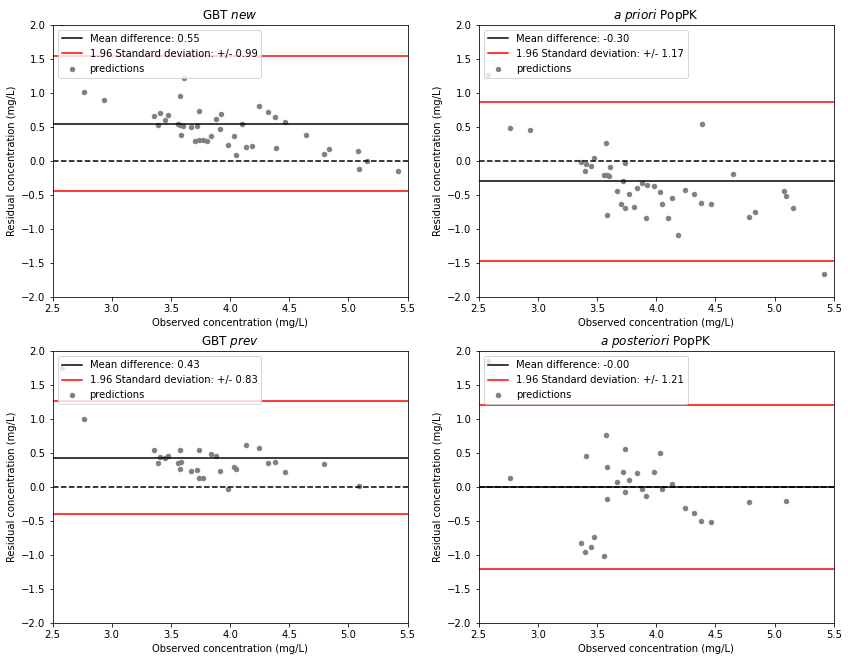

In [47]:
Y_val_plot1 = Y_val_plot_cbr
diff1 = diff_cbr
md1 = md_cbr
sd1 = sd_cbr

Y_val_plot2 = Y_val_plot_poppk
diff2 = diff_poppk
md2 = md_poppk
sd2 = sd_poppk

Y_val_plot3 = Y_val_plot_cbr_prev
diff3 = diff_cbr_prev
md3 = md_cbr_prev
sd3 = sd_cbr_prev

Y_val_plot4 = Y_val_plot_poppk_prev
diff4 = diff_poppk_prev
md4 = md_poppk_prev
sd4 = sd_poppk_prev
    
f, axes = plt.subplots(2, 2,figsize=(14,11))

if internal_test_bool:
    if log_plot:
        y_plot_limit = 1.5
        x_plot_limit = 3
    else:
        y_plot_limit = 270
else:
    if log_plot:
        y_plot_limit = 2
        x_plot_limit = 2.5
    else:
        y_plot_limit = 210

axes[0,0].scatter(Y_val_plot1,diff1,label='predictions',color='gray',s=20)
axes[0,0].axhline(md1,color='black',label='Mean difference: %.2f' % (md1))
axes[0,0].axhline(md1+1.96*sd1,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd1))
axes[0,0].axhline(md1-1.96*sd1,color='red')
axes[0,0].axhline(0,color='black',ls="--")
axes[0,0].set_xlabel('Observed concentration (mg/L)')
axes[0,0].set_ylabel('Residual concentration (mg/L)')
axes[0,0].legend(loc="upper left")
axes[0,0].set_title("GBT $\it{new}$")
axes[0,0].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[0,0].set_xlim((x_plot_limit,x_plot_limit+3))

axes[0,1].scatter(Y_val_plot2,diff2,label='predictions',color='gray',s=20)
axes[0,1].axhline(md2,color='black',label='Mean difference: %.2f' % (md2))
axes[0,1].axhline(md2+1.96*sd2,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd2))
axes[0,1].axhline(md2-1.96*sd2,color='red')
axes[0,1].axhline(0,color='black',ls="--")
axes[0,1].set_xlabel('Observed concentration (mg/L)')
axes[0,1].set_ylabel('Residual concentration (mg/L)')
axes[0,1].legend(loc="upper left")
axes[0,1].set_title("$\it{a}$ $\it{priori}$ PopPK")
axes[0,1].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[0,1].set_xlim((x_plot_limit,x_plot_limit+3))

axes[1,0].scatter(Y_val_plot3,diff3,label='predictions',color='gray',s=20)
axes[1,0].axhline(md3,color='black',label='Mean difference: %.2f' % (md3))
axes[1,0].axhline(md3+1.96*sd3,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd3))
axes[1,0].axhline(md3-1.96*sd3,color='red')
axes[1,0].axhline(0,color='black',ls="--")
axes[1,0].set_xlabel('Observed concentration (mg/L)')
axes[1,0].set_ylabel('Residual concentration (mg/L)')
axes[1,0].legend(loc="upper left")
axes[1,0].set_title("GBT $\it{prev}$")
axes[1,0].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[1,0].set_xlim((x_plot_limit,x_plot_limit+3))

axes[1,1].scatter(Y_val_plot4,diff4,label='predictions',color='gray',s=20)
axes[1,1].axhline(md4,color='black',label='Mean difference: %.2f' % (md4))
axes[1,1].axhline(md4+1.96*sd4,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd4))
axes[1,1].axhline(md4-1.96*sd4,color='red')
axes[1,1].axhline(0,color='black',ls="--")
axes[1,1].set_xlabel('Observed concentration (mg/L)')
axes[1,1].set_ylabel('Residual concentration (mg/L)')
axes[1,1].legend(loc="upper left")
axes[1,1].set_title("$\it{a}$ $\it{posteriori}$ PopPK")
axes[1,1].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[1,1].set_xlim((x_plot_limit,x_plot_limit+3))

if save:
    if internal_test_bool:
        f.savefig("figures/blandt_altman_guh.pdf")
        f.savefig("figures/blandt_altman_guh.jpeg")
        f.savefig("figures/blandt_altman_guh.svg")
    else:
        f.savefig("figures/blandt_altman_umcg.pdf")
        f.savefig("figures/blandt_altman_umcg.jpeg")
        f.savefig("figures/blandt_altman_umcg.svg")

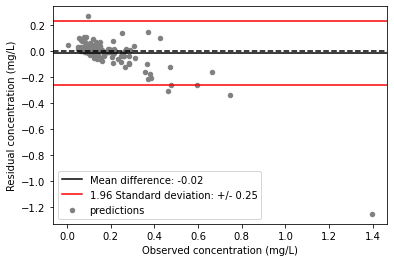

In [95]:
#annotate_val = False #Patient 2.0,11.0,4.0,3.0 = outliers

#annotate_train = False #Patient 66572,66663,63873 (only one measurement)

model = "PopPK_prev"

if model == "CB_weight":
    Y_val_plot = cb_weight_label 
    Y_val_plot_pred= cb_weight_pred
elif model == "CB_prev":
    Y_val_plot =  Y_cbr_test_prev 
    Y_val_plot_pred= y_pred_test_cbr_prev
elif model == "CB_new_var":
    Y_val_plot = Y_cbr_test_var
    Y_val_plot_pred= y_pred_test_cbr_var
elif model == "CB_new":
    Y_val_plot = Y_cbr_test_new 
    Y_val_plot_pred= y_pred_test_cbr_new
elif model == "GP_weight":
    Y_val_plot = real_conc
    Y_val_plot_pred= preds
elif model == "GP_prev":
    Y_val_plot = Y_val_prev_dest 
    Y_val_plot_pred= val_pred_prev
elif model == "GP_new":
    Y_val_plot = Y_val_new_dest 
    Y_val_plot_pred= val_pred_new
elif model == "PopPK":
    Y_val_plot = Y_test_popPK 
    Y_val_plot_pred= Y_popPK_pred
elif model == "PopPK_prev":
    Y_val_plot = Y_test_popPK_prev
    Y_val_plot_pred= Y_popPK_pred_prev

diff = np.subtract(Y_val_plot_pred,Y_val_plot)

md = np.mean(diff)
sd = np.std(diff)

plt.figure(figsize=(6,4))
plt.scatter(Y_val_plot,diff,label='predictions',color='gray',s=20)
#plt.plot((0,0), (300,0), ls="--", c=".3")
"""if annotate_val:
    for i in range(0,len(Y_val_plot)):
        plt.annotate(ID_val[i],(Y_val_plot[i],Y_val_plot_pred[i]))"""

plt.axhline(md,color='black',label='Mean difference: %.2f' % (md))
plt.axhline(md+1.96*sd,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd))
plt.axhline(md-1.96*sd,color='red')

"""coef= np.polyfit(Y_val_plot,diff,1)
poly1d_fn = np.poly1d(coef) 
Slope_Log_Fitted = poly1d_fn(1)-poly1d_fn(0)
plt.plot(Y_val_plot,poly1d_fn(Y_val_plot),color='blue',label='Interpolation: slope = {0:.2f}'.format(Slope_Log_Fitted))"""

plt.axhline(0,color='black',ls="--")
#plt.annotate(md,(0,300))
plt.xlabel('Observed concentration (mg/L)')
plt.ylabel('Residual concentration (mg/L)')
#plt.title('Bland-Altman plot: '+model)
plt.legend(loc="upper left")
#plt.xlim((0,300))
plt.ylim((-300,300))
#plt.savefig("figures/prevCon_prev_vs_ext_val.pdf")
#plt.plot(Y_pred,Y_test_tot,'o')
#plt.plot([0,250],[0,250], color='black')

# Concentration - Time plot

In [53]:
TVV = 6.18 #Vd of central compartiment by Sofie Dhaese Vd of 75kg patient
TVVP = 11.17 #Vd of peripheral compartiment by Sofie Dhaese
TVVT = TVV+TVVP #total Vd of both compartments

# Outputs the concentration (mg/L) at time t (hours) for a one-compartment model with IV bolus and continuous infusion
# Given the volume of distribution V (L), the elimination rate constant k (h^-1), the IV rate R (mg/h) and loading dose Dl (mg)
def bolus_iv_ct(V,k,R,Dl,t):
    return R/(V*k)+np.exp(-k*t)*(Dl/V-R/(V*k))

# Outputs the concentration (mg/L) at time t (hours) for a one-compartment model with IV bolus (over 30min) and continuous infusion
# Given the volume of distribution V (L), the elimination rate constant k (h^-1), the IV rate R (mg/h) and loading dose Dl (mg)
def bolus_30m_iv_ct(V,k,R,Dl,t):
    t_less_idx = np.max(np.where(t<=0.5))
    
    
    t_bol = t[0:t_less_idx]
    k_bol = k[0:t_less_idx]
    
    half_h_bolus =  Dl/(V*k_bol)-Dl/(V*k_bol)*np.exp(-k_bol*t_bol) #bolus IV infusion
    
    R_iv = R[t_less_idx:]
    t_iv = t[t_less_idx:]
    k_iv = k[t_less_idx:]
    
    start_iv = R_iv/(V*k_iv)+np.exp(-k_iv*(t_iv-0.5))*(Dl/(V*k_iv)-Dl/(V*k_iv)*np.exp(-k_iv*0.5)-R_iv/(V*k_iv)) #Cont IV infusion with started bolus

    return np.append(half_h_bolus,start_iv)

# Outputs the concentration (mg/L) at time t (hours) for a one-compartment model with IV bolus and continuous infusion
# Given the volume of distribution V (L), the elimination rate constant k (h^-1), the IV rate R (mg/h) and start concentration C0 (mg)
def iv_ct_start(V,k,R,C0,t):
    return R/(V*k)+np.exp(-k*t)*(C0)

# Outputs the concentration (mg/L) at time t (hours) after the termination of IV continuous infusion
# Given the volume of distribution V (L), the elimination rate constant k (h^-1) and the IV rate R (mg/h)
def stop_iv(V,k,R,t):
    return R/(V*k)*np.exp(-k*t)


# Outputs the elimination rate of a steady state concentration of continuous infusion
# Given the volume of distribution V (L), the elimination rate constant k (h^-1) and the concentration C (mg/L)
def get_el_rate(V,C,R):
    return np.divide(R,V*C)

# Outputs the volume of distribution V (L) dependent on the weight (kg)
def indv_vol(weight):
    return weight/70*(TVV)

# Outputs the IV rate (mg/h) for the given MIC target MIC (mg/L), elimination rate k (/hr) and volume of distribution V (L)
def get_iv_rate_ss_target(MIC,k,V):
    return MIC*k*V

# Outputs the maximal rate (/hr) based on the Michaelis Menten formula, no parallel linear elimination
# Given the elimination constant k (1/hr), MM constant (mg/L) and concentration C (mg/L)
def Vmax_MM(k,C,Km):
    return k*(Km+C)/C

# Outputs the IV rate (mg/h) for the given MIC target MIC (mg/L) assuming Michaelis Menten elimination 
# Elimination rate k (/hr), volume of distribution V (L), maximal rate Vmax (/hr) and Michaelis Menten constant Km (mg/L)
def get_iv_rate_ss_target_MM(MIC,k,V,Vmax,Km):
    return MIC*V*(Vmax*MIC)/(MIC+Km)

# Outputs the IV rate (mg/h) for the given MIC target MIC (mg/L) assuming parallel linear - Michaelis Menten elimination 
# Elimination rate k (/hr), volume of distribution V (L), maximal rate Vmax (/hr) and Michaelis Menten constant Km (mg/L)
def get_iv_rate_ss_target_MM_parallel(MIC,k,V,Vm,Km):
    a = -1/(V*k)
    b = Km+MIC+Vm/(V*k)
    c = -Vm
    D = b**2-4*a*c
    sol1 = (-b+np.sqrt(D))/(2*a)
    sol2 = (-b-np.sqrt(D))/(2*a)
    
    return sol2

In [54]:
test_df_cbr_var = test_df_cbr_var.reset_index().drop(columns=["index"])

In [55]:
test_df_cbr_var.PatientID.value_counts()

71695    10
64381     8
68666     7
66481     7
66653     6
69801     6
64514     5
66830     5
70804     5
70467     5
71496     5
69970     4
63480     4
71731     4
61914     4
66502     4
66752     4
69524     3
67003     3
67770     3
66661     3
71785     3
69541     3
65152     3
68746     3
64238     2
65587     2
64292     2
63013     2
67589     2
71212     2
67586     2
63647     2
69174     2
68420     2
64858     2
67166     2
70754     2
61935     2
66664     2
65143     2
64078     2
Name: PatientID, dtype: int64

In [56]:
test_df_cbr_var[test_df_cbr_var.PatientID==67770]

,PatientID,Age,Length,Weight,Race,HospSurvival,ICUAdmTime,Diagnose,HospAdmTime,DateConc,concentration,SOFA,Lactate,Serum Creat,Creat_u,Cl8u,HCT,Thrombo,WBC,RBC,Bilirubine,HgB,Albumine,Fluid Balance,INtot,OUTtot,EPI,NOREPI,DOBU,DOPA,MILRI,PHENYL,VASOPRES,ICUSurvival.y,CumSum,durAB,Temp,startAB,stopAB,KDIGO,Neuro,hours_since_start_treatment,days_since_hosp,days_since_icu,Creat_u_orig,Creat_u_orig_-999,Creat_u_orig_+999,Creat_u_-999,Creat_u_+999,Creat_u_orig_available,Creat_u_available,Cl8u_orig,Cl8u_orig_-999,Cl8u_orig_+999,Cl8u_-999,Cl8u_+999,Cl8u_orig_available,Cl8u_available,Temp_orig,Temp_orig_-999,Temp_orig_+999,Temp_-999,Temp_+999,Temp_orig_available,Temp_available,Gender.M,Adm.category_medical,Adm.category_surgical,Adm.category_trauma,Duration,DoseAdm,prevCon,concentration_diff,DoseHour,ClCr
82,67770,63,170,86.0,Caucasisch,1,35:00.0,Resectie obstruerend rectosgmoidcarcinoom,16:00.0,00:00.0,86.2,2,5.4,0.78,33.8,58.41010,39.0,226.0,8.25,3.64,0.7,12.9,27,-188.0,2666.0,2855,0,0,0,0,0,0,0,1,8021.975067,4,36.5,00:00.0,28:22.0,0.0,0,15,5,4,33.8,33.8,33.8,33.8,33.8,1,1,58.410100,58.4101,58.4101,58.41010,58.41010,1,1,36.5,36.5,36.5,36.5,36.5,1,1,1,0,1,0,15,8021.975067,0.0,0.0,534.798338,58.410100
83,67770,63,170,86.0,Caucasisch,1,35:00.0,Resectie obstruerend rectosgmoidcarcinoom,16:00.0,00:00.0,74.3,3,7.7,0.86,43.1,65.70955,37.2,246.0,10.89,3.43,0.5,11.9,27,-258.0,2696.0,2955,0,0,0,0,0,0,0,1,21967.875680,4,37.2,00:00.0,28:22.0,0.0,0,39,6,5,43.1,43.1,43.1,43.1,43.1,1,1,111.438272,-999.0000,999.0000,65.70955,65.70955,0,1,37.2,37.2,37.2,37.2,37.2,1,1,1,0,1,0,24,13945.900610,86.2,-11.9,581.079192,90.536619
84,67770,63,170,86.0,Caucasisch,1,35:00.0,Resectie obstruerend rectosgmoidcarcinoom,16:00.0,00:00.0,70.3,3,6.8,0.86,61.2,73.00900,34.7,235.0,10.49,3.18,0.5,11.1,28,-477.0,2717.0,3195,0,0,0,0,0,0,0,1,37584.033860,4,37.1,00:00.0,28:22.0,0.0,0,63,7,6,61.2,61.2,61.2,61.2,61.2,1,1,73.009000,73.0090,73.0090,73.00900,73.00900,1,1,37.1,37.1,37.1,37.1,37.1,1,1,1,0,1,0,24,15616.158180,74.3,-4.0,650.673257,73.009000


In [57]:
patient = 82
dur_1 = test_df_cbr_var.Duration.values[patient]
dur_2 = test_df_cbr_var.Duration.values[patient+1]
dur_3 = test_df_cbr_var.Duration.values[patient+2]

In [58]:
Doses_1 = np.repeat(test_df_cbr_var.DoseHour.values[patient],dur_1*10-1)[0:dur_1*10]
Doses_2 = np.arange(test_df_cbr_var.DoseHour.values[patient],test_df_cbr_var.DoseHour.values[patient+1],(test_df_cbr_var.DoseHour.values[patient+1]-test_df_cbr_var.DoseHour.values[patient])/(dur_2*10))[0:dur_2*10]
Doses_3 = np.arange(test_df_cbr_var.DoseHour.values[patient+1],test_df_cbr_var.DoseHour.values[patient+2],(test_df_cbr_var.DoseHour.values[patient+2]-test_df_cbr_var.DoseHour.values[patient+1])/(dur_3*10))[0:dur_3*10]
Doses_4 = np.repeat(test_df_cbr_var.DoseHour.values[patient+2],100) 

Doses = np.hstack([Doses_1,Doses_2,Doses_3,Doses_4])

In [59]:
pred_1 = np.repeat(y_pred_test_cbr_var[patient],dur_1*10-1)[0:dur_1*10]
pred_2 = np.arange(y_pred_test_cbr_var[patient],y_pred_test_cbr_var[patient+1],(y_pred_test_cbr_var[patient+1]-y_pred_test_cbr_var[patient])/(dur_2*10))[0:dur_2*10]
pred_3 = np.arange(y_pred_test_cbr_var[patient+1],y_pred_test_cbr_var[patient+2],(y_pred_test_cbr_var[patient+2]-y_pred_test_cbr_var[patient+1])/(dur_3*10))[0:dur_3*10]
pred_4 = np.repeat(y_pred_test_cbr_var[patient+2],100) 

pred = np.hstack([pred_1,pred_2,pred_3,pred_4])

In [60]:
V_pat_0 = indv_vol(test_df_cbr_var.Weight.values[patient])
k_pat_0 = get_el_rate(V_pat_0,pred,Doses)

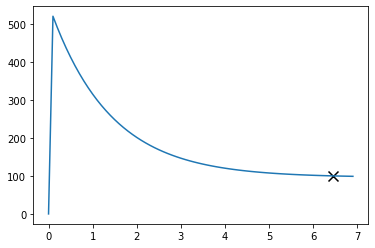

In [91]:
limit_steady = 4
Hours_test = np.arange(0.1,7,0.1)
plt.plot(np.append(0,Hours_test),np.append(0,Doses[0]/(V_pat_0*k_pat_0[0])+np.exp(-k_pat_0[0]*Hours_test)*((4000-Doses[0])/V_pat_0)))
plt.scatter(-np.log(V_pat_0*limit_steady/(4000-Doses[0]))/k_pat_0[0],limit_steady+Doses[0]/(V_pat_0*k_pat_0[0]),marker="x",color='black',s=100)

Text(0.5, 0, 'Time (hours)')

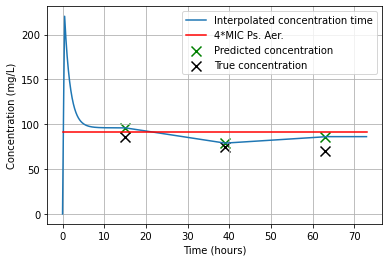

In [61]:
max_Hours = dur_1+dur_2+dur_3+10#27+48+24+10#test_df_cbr_var.Duration.values[patient]+10
Hours = np.arange(0.1,max_Hours,0.1)
Hours_stop_iv = np.arange(0.1,4,0.1)

#plt.plot(np.append(np.append(0,Hours),Hours_stop_iv+max_Hours),np.append(np.append(0,bolus_iv_ct(V_pat_0,k_pat_0,test_df_cbr_var.DoseHour.values[patient],4000,Hours)),stop_iv(V_pat_0,k_pat_0,test_df_cbr_var.DoseHour.values[patient],Hours_stop_iv)),label="Predicted concentration time")

#plt.plot(np.append(0,Hours),np.append(0,bolus_iv_ct(V_pat_0,k_pat_0,Doses,4000,Hours)),label="Interpolated concentration time")
plt.plot(np.append(0,Hours),np.append(0,bolus_30m_iv_ct(V_pat_0,k_pat_0,Doses,4000,Hours)),label="Interpolated concentration time")


plt.scatter(test_df_cbr_var.Duration.values[patient],y_pred_test_cbr_var[patient],marker="x",color='green',s=100,label='Predicted concentration')
plt.scatter(dur_1+dur_2,y_pred_test_cbr_var[patient+1],marker="x",color='green',s=100)
plt.scatter(dur_1+dur_2+dur_3,y_pred_test_cbr_var[patient+2],marker="x",color='green',s=100)
plt.scatter(test_df_cbr_var.Duration.values[patient],test_df_cbr_var.concentration.values[patient],marker="x",color='black',s=100,label='True concentration')
plt.scatter(dur_1+dur_2,test_df_cbr_var.concentration.values[patient+1],marker="x",color='black',s=100)
plt.scatter(dur_1+dur_2+dur_3,test_df_cbr_var.concentration.values[patient+2],marker="x",color='black',s=100)
plt.plot([0,max_Hours],[4*16/0.7,4*16/0.7],color='red',label="4*MIC Ps. Aer.")
plt.legend()
plt.grid()
plt.ylabel("Concentration (mg/L)")
plt.xlabel("Time (hours)")

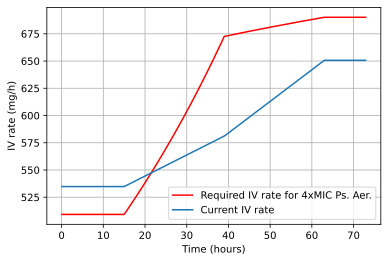

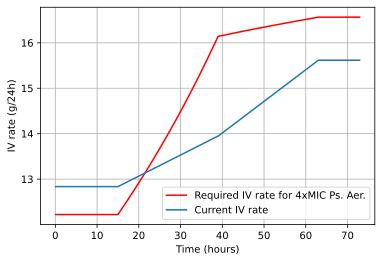

In [640]:
Km_p0 = 37.09
#Vmax_p0 = 353.37#Vmax_MM(k_pat_0,pred,Km_p0) #Km is from paper of Sofie Dhaese
Vmax_p0 = Vmax_MM(k_pat_0,pred,Km_p0) #Km is from paper of Sofie Dhaese
kc_p0 = K_c_MM(k_pat_0,pred,Km_p0,Vmax_p0)

req_rates = get_iv_rate_ss_target(4*16/0.7,k_pat_0,V_pat_0)
#req_rates = get_iv_rate_ss_target_MM(4*16/0.7,k_pat_0,V_pat_0,Vmax_p0,Km_p0)
#req_rates = get_iv_rate_ss_target_MM_parallel(4*16/0.7,k_pat_0,V_pat_0,Vmax_p0,Km_p0)

plt.plot(Hours,req_rates,color='red',label='Required IV rate for 4xMIC Ps. Aer.')
plt.plot(Hours,Doses,label='Current IV rate')
plt.grid()
plt.legend()
plt.ylabel("IV rate (mg/h)")
plt.xlabel("Time (hours)")
plt.show()

plt.plot(Hours,req_rates*24/1000,color='red',label='Required IV rate for 4xMIC Ps. Aer.')
plt.plot(Hours,Doses*24/1000,label='Current IV rate')
plt.grid()
plt.legend()
plt.ylabel("IV rate (g/24h)")
plt.xlabel("Time (hours)")
plt.show()


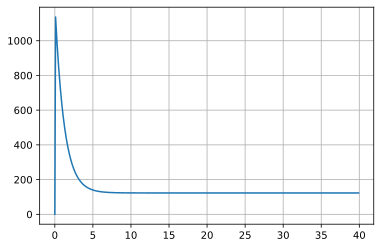

In [601]:
patient = 68

V_pat_0 = indv_vol(test_df_cbr_var.Weight.values[patient])
k_pat_0 = get_el_rate(V_pat_0,y_pred_test_cbr_var[patient],test_df_cbr_var.DoseHour.values[patient])

Hours = np.arange(0.1,40,0.1)

plt.plot(np.append(0,Hours),np.append(0,bolus_iv_ct(V_pat_0,k_pat_0,test_df_cbr_var.DoseHour.values[patient],4000,Hours)),label="Predicted concentration time")
plt.grid()

## Data size improvements

In [ ]:


RMSE_t = []
MAE_t = []
R2_t = []

for s in np.arange(0.025,1.025,0.025):
    print("Current size = "+str(s*100)+"%")
    RMSE_s = []
    MAE_s = []
    R2_s = []
    for i in range(50):
        np.random.seed(i)
        idxs_train_size = np.random.choice(np.arange(0,len(X_cbr_train_var)),size=int(s*len(X_cbr_train_var)),replace=False)
        X_cbr_train_size = X_cbr_train_var.values[idxs_train_size]
        Y_cbr_train_size = Y_cbr_train_var[idxs_train_size]

        #boost_from_average on false to get to 0.17.5 values
        cbr_var = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha=0.5',
                                        iterations=it_q50_var, use_best_model=False, depth = 4,l2_leaf_reg=12,border_count=213,bootstrap_type='Bayesian',boost_from_average=False)
        cbr_var.fit(X_cbr_train_size, Y_cbr_train_size, cat_features=cat_cols_idx_var, eval_set=(X_cbr_test_var, Y_cbr_test_var))
        
        y_pred_test_cbr_var = cbr_var.predict(X_cbr_test_var)
        
        R2,RMSE,MAE,ME = scores_calc_print(y_pred_test_cbr_var,Y_cbr_test_var,False)
        RMSE_s.append(RMSE)
        MAE_s.append(MAE)
        R2_s.append(R2)
    RMSE_t.append(RMSE_s)
    MAE_t.append(MAE_s)
    R2_t.append(R2_s)
    
RMSE_t = np.array(RMSE_t)
MAE_t = np.array(MAE_t)
R2_t = np.array(R2_t)

In [ ]:
plt.plot(np.arange(0.025,1.025,0.025)*len(X_cbr_train_var),np.mean(RMSE_t,axis=1),label="mean")
plt.plot(np.arange(0.025,1.025,0.025)*len(X_cbr_train_var),RMSE_t,alpha=0.1)
plt.xlabel("Dataset size (samples)")
plt.ylabel("RMSE")
plt.legend()
plt.show()

plt.plot(np.arange(0.025,1.025,0.025)*len(X_cbr_train_var),np.mean(MAE_t,axis=1),label="mean")
plt.plot(np.arange(0.025,1.025,0.025)*len(X_cbr_train_var),MAE_t,alpha=0.1)
plt.xlabel("Dataset size (samples)")
plt.ylabel("MAE")
plt.legend()
plt.show()

plt.plot(np.arange(0.025,1.025,0.025)*len(X_cbr_train_var),np.mean(R2_t,axis=1),label="mean")
plt.plot(np.arange(0.025,1.025,0.025)*len(X_cbr_train_var),R2_t,alpha=0.1)
plt.xlabel("Dataset size (samples)")
plt.ylabel("R2")
plt.legend()
plt.show()